# Observing pickle file data

In [22]:
import pandas as pd
import pickle
import os

def save_pickled_dataframes_to_csv(pickle_file_path, output_dir):
    # Load the pickle file
    with open(pickle_file_path, 'rb') as file:
        data = pickle.load(file)

    # Check and create output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Iterate through the dictionary and save each DataFrame to a CSV
    for key, df in data.items():
        if isinstance(df, pd.DataFrame):
            csv_path = os.path.join(output_dir, f"{key}.csv")
            df.to_csv(csv_path, index=False)
            print(f"Saved {key} to {csv_path}")

# Example usage
pickle_file_path = '/run/user/1021/gvfs/smb-share:server=ait-pdfs.win.dtu.dk,share=department/Man/PUBLIC/4233-81647-eMOTIONAL-Cities/5 Data/ECDTU/E4/completed/101/Data/11_10/activity_data.pickle'
output_dir = 'testing2'
save_pickled_dataframes_to_csv(pickle_file_path, output_dir)


Saved eda_subj_activity to testing2/eda_subj_activity.csv
Saved eda_subj_activity_concat to testing2/eda_subj_activity_concat.csv
Saved temp_subj_activity to testing2/temp_subj_activity.csv
Saved temp_subj_activity_concat to testing2/temp_subj_activity_concat.csv
Saved eda_scrs_subj_activity to testing2/eda_scrs_subj_activity.csv
Saved eda_scrs_subj_activity_concat to testing2/eda_scrs_subj_activity_concat.csv
Saved ibi_subj_activity to testing2/ibi_subj_activity.csv
Saved ibi_subj_activity_concat to testing2/ibi_subj_activity_concat.csv
Saved hr_subj_activity to testing2/hr_subj_activity.csv
Saved hr_subj_activity_concat to testing2/hr_subj_activity_concat.csv
Saved ppg_onsets_subj_activity to testing2/ppg_onsets_subj_activity.csv
Saved ppg_onsets_subj_activity_concat to testing2/ppg_onsets_subj_activity_concat.csv
Saved eda_subj to testing2/eda_subj.csv
Saved eda_scrs_metrics to testing2/eda_scrs_metrics.csv
Saved ibi_subj to testing2/ibi_subj.csv


# Preprocessing all days from 1 Person

In [1]:
import pandas as pd
import numpy as np
import os
import pickle

# Constants
PAD_VALUE = 0  # Use a distinct pad value to easily identify padded areas
TOKEN_OFFSET = 15  # For mode differentiation
LAT_LON_PAD = 0  # Use a distinct pad value for latitude and longitude

def preprocess_day_data(pickle_file, traffic_dict, building_dict):
    with open(pickle_file, 'rb') as file:
        data = pickle.load(file)
    
    df = data['hr_subj']  # Adjust the key based on your data structure
    
    # Fill NA values for critical columns before processing
    df['lat'] = df['lat'].fillna(LAT_LON_PAD)
    df['lon'] = df['lon'].fillna(LAT_LON_PAD)

    # Define transport modes
    transport_modes = {"Train", "Bicycle", "Bus", "Car/Truck", "Change Travel Mode/Transfer", "Foot"}

    total_seconds = len(df)
    emotions = df['Values'].values
    latitudes = np.full(total_seconds, LAT_LON_PAD, dtype=float)
    longitudes = np.full(total_seconds, LAT_LON_PAD, dtype=float)
    activities = np.full(total_seconds, PAD_VALUE, dtype=int)
    modes = np.full(total_seconds, PAD_VALUE, dtype=int)
    traffic_lights = np.full(total_seconds, LAT_LON_PAD, dtype=float)
    buildings = np.full(total_seconds, LAT_LON_PAD, dtype=float)
    durations = np.zeros(total_seconds, dtype=int)

    activity_tokens = {activity: i + 1 for i, activity in enumerate(df['Activity'].unique()) if activity not in transport_modes}
    mode_tokens = {mode: i + TOKEN_OFFSET for i, mode in enumerate(transport_modes)}

    previous_activity = None
    activity_start_idx = 0  # Track the start index of each activity

    for i in range(total_seconds):
        current_activity = df.at[i, 'Activity']

        if current_activity in transport_modes:
            if current_activity != previous_activity:
                modes[i] = mode_tokens.get(current_activity, PAD_VALUE)

        # Detect activity change
        if current_activity != previous_activity:
            if previous_activity is not None:
                # Set the duration for the previous activity block
                durations[activity_start_idx] = i - activity_start_idx

                # Pad all values between the start and end of the previous activity
                latitudes[activity_start_idx+1:i] = LAT_LON_PAD
                longitudes[activity_start_idx+1:i] = LAT_LON_PAD
                activities[activity_start_idx+1:i] = PAD_VALUE
                modes[activity_start_idx+1:i] = PAD_VALUE
                traffic_lights[activity_start_idx+1:i] = LAT_LON_PAD
                buildings[activity_start_idx+1:i] = LAT_LON_PAD

            # Update new activity start index and store values at the first occurrence
            activity_start_idx = i
            activities[i] = activity_tokens.get(current_activity, PAD_VALUE)
            latitudes[i] = df.at[i, 'lat']
            longitudes[i] = df.at[i, 'lon']
            traffic_lights[i] = traffic_dict.get(f"{df.at[i, 'lat']:.10f}_{df.at[i, 'lon']:.10f}", LAT_LON_PAD)
            buildings[i] = building_dict.get(f"{df.at[i, 'lat']:.10f}_{df.at[i, 'lon']:.10f}", LAT_LON_PAD)

        previous_activity = current_activity

    # Set duration for the last activity block
    durations[activity_start_idx] = total_seconds - activity_start_idx

    return {
        'emotions': emotions,
        'latitudes': latitudes,
        'longitudes': longitudes,
        'durations': durations,
        'activities': activities,
        'modes': modes,
        'traffic_lights': traffic_lights,
        'buildings': buildings
    }


In [2]:
import os
import pandas as pd

def process_all_days(data_folder, output_folder, traffic_dict, building_dict):
    for root, dirs, files in os.walk(data_folder):
        for day_folder in dirs:
            pickle_path = os.path.join(root, day_folder, 'day_processed_data.pickle')
            if os.path.exists(pickle_path):
                print(f"Processing {pickle_path}...")
                day_data = preprocess_day_data(pickle_path, traffic_dict, building_dict)
                # Convert dictionary to DataFrame
                df = pd.DataFrame(day_data)
                output_path = os.path.join(output_folder, day_folder + '_processed.csv')
                df.to_csv(output_path, index=False)
                print(f"Data saved to {output_path}")
            else:
                print(f"No data file found for {day_folder}")


# Example usage
data_folder = '/run/user/1021/gvfs/smb-share:server=ait-pdfs.win.dtu.dk,share=department/Man/PUBLIC/4233-81647-eMOTIONAL-Cities/5 Data/ECDTU/E4/completed/101/Data'
output_folder = 'preprocessed'
traffic_dict = {}  # Assume this is loaded or defined somewhere
building_dict = {}  # Assume this is loaded or defined somewhere

process_all_days(data_folder, output_folder, traffic_dict, building_dict)


Processing /run/user/1021/gvfs/smb-share:server=ait-pdfs.win.dtu.dk,share=department/Man/PUBLIC/4233-81647-eMOTIONAL-Cities/5 Data/ECDTU/E4/completed/101/Data/11_14/day_processed_data.pickle...


Data saved to preprocessed/11_14_processed.csv
Processing /run/user/1021/gvfs/smb-share:server=ait-pdfs.win.dtu.dk,share=department/Man/PUBLIC/4233-81647-eMOTIONAL-Cities/5 Data/ECDTU/E4/completed/101/Data/11_24/day_processed_data.pickle...
Data saved to preprocessed/11_24_processed.csv
Processing /run/user/1021/gvfs/smb-share:server=ait-pdfs.win.dtu.dk,share=department/Man/PUBLIC/4233-81647-eMOTIONAL-Cities/5 Data/ECDTU/E4/completed/101/Data/11_12/day_processed_data.pickle...
Data saved to preprocessed/11_12_processed.csv
Processing /run/user/1021/gvfs/smb-share:server=ait-pdfs.win.dtu.dk,share=department/Man/PUBLIC/4233-81647-eMOTIONAL-Cities/5 Data/ECDTU/E4/completed/101/Data/11_21/day_processed_data.pickle...
Data saved to preprocessed/11_21_processed.csv
Processing /run/user/1021/gvfs/smb-share:server=ait-pdfs.win.dtu.dk,share=department/Man/PUBLIC/4233-81647-eMOTIONAL-Cities/5 Data/ECDTU/E4/completed/101/Data/11_22/day_processed_data.pickle...
Data saved to preprocessed/11_22_pro

In [2]:
import numpy as np
import pandas as pd
import os
import pickle

# Constants
PAD_VALUE = 0  # Use a distinct pad value to easily identify padded areas
TOKEN_OFFSET = 15  # For mode differentiation
LAT_LON_PAD = 0  # Use a distinct pad value for latitude and longitude
MAX_SIMU_TOKENS = 16
N_TRACKS = 4  # Number of tracks
N_BARS = 2  # Assuming 2 bars for simplicity, bars = days
RESOLUTION = 8 # Assuming 8 timesteps per beat, adjust as needed

# Calculate window size and stride for sliding windows
window_size = N_BARS * 4 * RESOLUTION
stride = window_size

def preprocess_day_data(csv_file):
    df = pd.read_csv(csv_file)
    
    # Assuming these columns are present in your CSV files
    emotions = df['emotions'].values
    latitudes = df['latitudes'].values
    longitudes = df['longitudes'].values
    durations = df['durations'].values
    activities = df['activities'].values
    modes = df['modes'].values
    traffic_lights = df['traffic_lights'].values
    buildings = df['buildings'].values

    return emotions, latitudes, longitudes, durations, activities, modes, traffic_lights, buildings, len(df)

def preprocess_sample_data(input_dir, output_dir):
    csv_files = [f for f in os.listdir(input_dir) if f.endswith('_processed.csv')]

    for sample_idx, csv_file in enumerate(csv_files):
        file_path = os.path.join(input_dir, csv_file)
        data = preprocess_day_data(file_path)
        emotions, latitudes, longitudes, durations, activities, modes, traffic_lights, buildings, n_timesteps = data

        full_c_tensor = np.zeros((N_TRACKS, n_timesteps, MAX_SIMU_TOKENS, 2), dtype=np.float32)
        for t in range(n_timesteps):
            full_c_tensor[0, t, :, :] = [emotions[t], 1]
            full_c_tensor[1, t, 0, :] = [latitudes[t], durations[t]]
            full_c_tensor[1, t, 1, :] = [longitudes[t], durations[t]]
            full_c_tensor[1, t, 2, :] = [traffic_lights[t], durations[t]]
            full_c_tensor[1, t, 3, :] = [buildings[t], durations[t]]
            full_c_tensor[2, t, :, :] = [activities[t], durations[t]]
            full_c_tensor[3, t, :, :] = [modes[t], durations[t]]

        full_s_tensor = np.any(full_c_tensor != 0, axis=(2, 3)).astype(int)

        for start_idx in range(0, n_timesteps - window_size + 1, stride):
            c_tensor_segment = full_c_tensor[:, start_idx:start_idx + window_size, :, :]
            s_tensor_segment = full_s_tensor[:, start_idx:start_idx + window_size]
            sample_filepath = os.path.join(output_dir, f"sample_{sample_idx}_segment_{start_idx // (stride)}.npz")
            np.savez(sample_filepath, c_tensor=c_tensor_segment, s_tensor=s_tensor_segment)
            print(f"File saved: {sample_filepath}")

# Example usage
input_dir = 'preprocessed'  # Folder containing the processed CSV files
output_dir = 'preprocessed_npz'  # Folder where the output files should be saved
# preprocess_sample_data(input_dir, output_dir)


File saved: preprocessed_npz/sample_0_segment_0.npz
File saved: preprocessed_npz/sample_0_segment_1.npz
File saved: preprocessed_npz/sample_0_segment_2.npz
File saved: preprocessed_npz/sample_0_segment_3.npz
File saved: preprocessed_npz/sample_0_segment_4.npz
File saved: preprocessed_npz/sample_0_segment_5.npz
File saved: preprocessed_npz/sample_0_segment_6.npz
File saved: preprocessed_npz/sample_0_segment_7.npz
File saved: preprocessed_npz/sample_0_segment_8.npz
File saved: preprocessed_npz/sample_0_segment_9.npz
File saved: preprocessed_npz/sample_0_segment_10.npz
File saved: preprocessed_npz/sample_0_segment_11.npz
File saved: preprocessed_npz/sample_0_segment_12.npz
File saved: preprocessed_npz/sample_0_segment_13.npz
File saved: preprocessed_npz/sample_0_segment_14.npz
File saved: preprocessed_npz/sample_0_segment_15.npz
File saved: preprocessed_npz/sample_0_segment_16.npz
File saved: preprocessed_npz/sample_0_segment_17.npz
File saved: preprocessed_npz/sample_0_segment_18.npz
Fil

In [3]:
file_path = "/home/elygao/preprocessed_npz/sample_0_segment_0.npz"

# Load the .npz file
data = np.load(file_path)

# Access the tensors
c_tensor = data['c_tensor']
s_tensor = data['s_tensor']

# Print their shapes
print(f'Shape of c_tensor: {c_tensor.shape}')
print(f'Shape of s_tensor: {s_tensor.shape}')

Shape of c_tensor: (4, 64, 16, 2)
Shape of s_tensor: (4, 64)


In [17]:
c_tensor[0,0:63,0:4,0]

array([[56.  , 56.  , 56.  , 56.  ],
       [56.  , 56.  , 56.  , 56.  ],
       [56.67, 56.67, 56.67, 56.67],
       [56.75, 56.75, 56.75, 56.75],
       [56.8 , 56.8 , 56.8 , 56.8 ],
       [57.  , 57.  , 57.  , 57.  ],
       [57.29, 57.29, 57.29, 57.29],
       [59.5 , 59.5 , 59.5 , 59.5 ],
       [61.89, 61.89, 61.89, 61.89],
       [64.1 , 64.1 , 64.1 , 64.1 ],
       [65.55, 65.55, 65.55, 65.55],
       [66.58, 66.58, 66.58, 66.58],
       [67.23, 67.23, 67.23, 67.23],
       [67.79, 67.79, 67.79, 67.79],
       [67.8 , 67.8 , 67.8 , 67.8 ],
       [67.81, 67.81, 67.81, 67.81],
       [67.76, 67.76, 67.76, 67.76],
       [67.72, 67.72, 67.72, 67.72],
       [67.63, 67.63, 67.63, 67.63],
       [67.85, 67.85, 67.85, 67.85],
       [68.19, 68.19, 68.19, 68.19],
       [68.55, 68.55, 68.55, 68.55],
       [68.83, 68.83, 68.83, 68.83],
       [69.17, 69.17, 69.17, 69.17],
       [69.4 , 69.4 , 69.4 , 69.4 ],
       [69.54, 69.54, 69.54, 69.54],
       [69.96, 69.96, 69.96, 69.96],
 

# Using Feature Extracted HR Data

In [65]:
import pandas as pd
import numpy as np
import os
import pickle

def calculate_hr_features(df):
    """Calculate heart rate features for each activity."""
    if df.empty:
        return pd.Series({
            'mean_hr': None, 'std_hr': None, 'min_hr': None, 'max_hr': None,
            'rmssd': None, 'cv_hr': None, 'skewness': None, 'kurtosis': None, 'IQR': None
        })
    return pd.Series({
        'mean_hr': df['Values'].mean(),
        'std_hr': df['Values'].std(),
        'min_hr': df['Values'].min(),
        'max_hr': df['Values'].max(),
        'rmssd': np.sqrt(np.mean(np.diff(df['Values'].dropna().values)**2)),
        'cv_hr': df['Values'].std() / df['Values'].mean() if df['Values'].mean() != 0 else 0,
        'skewness': df['Values'].skew(),
        'kurtosis': df['Values'].kurt(),
        'IQR': np.subtract(*np.percentile(df['Values'].dropna(), [75, 25]))
    })

def preprocess_day_data(pickle_file, traffic_dict, building_dict):
    with open(pickle_file, 'rb') as file:
        data = pickle.load(file)
    
    df = data['hr_subj']
    df['lat'] = df['lat'].fillna(0)
    df['lon'] = df['lon'].fillna(0)

    transport_modes = {"train", "bicycle", "bus", "car/truck", "change travel mode/transfer", "foot", "metro"}
    mode_tokens = {mode: i + 100 for i, mode in enumerate(transport_modes)}
    
    activities = {"home", "work related", "work", "exercise/play sports", "socialize", "education", "shopping", "errands", "accompany/dropoff/pickup", "medical", "eat out", "entertainment", "community", "second home", "other"}
    activity_tokens = {act: i + 1 for i, act in enumerate(activities)}

    results = []
    hr_features_list = []

    previous_activity = None
    activity_start_idx = 0
    previous_is_mode = False

    for i, row in df.iterrows():
        current_activity = row['Activity'].lower().strip()
        current_is_mode = current_activity in transport_modes

        if current_activity != previous_activity:
            if previous_activity is not None:
                activity_segment = df.iloc[activity_start_idx:i]
                duration = i - activity_start_idx
                if duration > 0:
                    results.append({
                        'initial_activity': previous_activity,
                        'activity': activity_tokens.get(previous_activity, 0) if not previous_is_mode else 0,
                        'latitude': activity_segment['lat'].iloc[0],
                        'longitude': activity_segment['lon'].iloc[0],
                        'mode': mode_tokens.get(previous_activity, 0) if previous_is_mode else 0,
                        'traffic_light': traffic_dict.get(f"{activity_segment['lat'].iloc[0]:.10f}_{activity_segment['lon'].iloc[0]:.10f}", 0),
                        'building': building_dict.get(f"{activity_segment['lat'].iloc[0]:.10f}_{activity_segment['lon'].iloc[0]:.10f}", 0),
                        'duration': duration
                    })
                    hr_features = calculate_hr_features(activity_segment)
                    hr_features.name = f"{previous_activity}_{activity_start_idx}"
                    hr_features_list.append(hr_features)

            activity_start_idx = i
            previous_activity = current_activity
            previous_is_mode = current_is_mode

    # Handle the last segment
    if previous_activity is not None and activity_start_idx < len(df):
        activity_segment = df.iloc[activity_start_idx:]
        duration = len(df) - activity_start_idx
        if duration > 0:
            results.append({
                'initial_activity': previous_activity,
                'activity': activity_tokens.get(previous_activity, 0) if not previous_is_mode else 0,
                'latitude': activity_segment['lat'].iloc[0],
                'longitude': activity_segment['lon'].iloc[0],
                'mode': mode_tokens.get(previous_activity, 0) if previous_is_mode else 0,
                'traffic_light': traffic_dict.get(f"{activity_segment['lat'].iloc[0]:.10f}_{activity_segment['lon'].iloc[0]:.10f}", 0),
                'building': building_dict.get(f"{activity_segment['lat'].iloc[0]:.10f}_{activity_segment['lon'].iloc[0]:.10f}", 0),
                'duration': duration
            })
            hr_features = calculate_hr_features(activity_segment)
            hr_features.name = f"{previous_activity}_{activity_start_idx}"
            hr_features_list.append(hr_features)

    final_data_df = pd.DataFrame(results)
    hr_features_df = pd.DataFrame(hr_features_list)
    hr_features_df.index = [f.name for f in hr_features_list]  # Set index to activity names with their start index

    return final_data_df, hr_features_df


In [66]:
import os
import pandas as pd

def process_all_days(data_folder, output_folder, traffic_dict, building_dict):
    for root, dirs, files in os.walk(data_folder):
        for day_folder in dirs:
            pickle_path = os.path.join(root, day_folder, 'day_processed_data.pickle')
            if os.path.exists(pickle_path):
                print(f"Processing {pickle_path}...")
                # Assuming preprocess_day_data returns two dataframes: final_data_df and hr_features_df
                final_data_df, hr_features_df = preprocess_day_data(pickle_path, traffic_dict, building_dict)

                # Check and create output directory if it doesn't exist
                if not os.path.exists(output_folder):
                    os.makedirs(output_folder)

                # Save the final_data DataFrame
                final_data_output_path = os.path.join(output_folder, day_folder + '_final_data.csv')
                final_data_df.to_csv(final_data_output_path, index=False)
                print(f"Final data saved to {final_data_output_path}")

                # Save the hr_features DataFrame
                hr_features_output_path = os.path.join(output_folder, day_folder + '_hr_features.csv')
                hr_features_df.to_csv(hr_features_output_path, index=False)
                print(f"Heart rate features saved to {hr_features_output_path}")
            else:
                print(f"No data file found for {day_folder}")

# Example usage
data_folder = '/run/user/1021/gvfs/smb-share:server=ait-pdfs.win.dtu.dk,share=department/Man/PUBLIC/4233-81647-eMOTIONAL-Cities/5 Data/ECDTU/E4/completed/101/Data'
output_folder = 'preprocessed_by_activity'
traffic_dict = {}  # Assume this is loaded or defined somewhere
building_dict = {}  # Assume this is loaded or defined somewhere

process_all_days(data_folder, output_folder, traffic_dict, building_dict)


Processing /run/user/1021/gvfs/smb-share:server=ait-pdfs.win.dtu.dk,share=department/Man/PUBLIC/4233-81647-eMOTIONAL-Cities/5 Data/ECDTU/E4/completed/101/Data/11_14/day_processed_data.pickle...
Final data saved to preprocessed_by_activity/11_14_final_data.csv
Heart rate features saved to preprocessed_by_activity/11_14_hr_features.csv
Processing /run/user/1021/gvfs/smb-share:server=ait-pdfs.win.dtu.dk,share=department/Man/PUBLIC/4233-81647-eMOTIONAL-Cities/5 Data/ECDTU/E4/completed/101/Data/11_24/day_processed_data.pickle...
Final data saved to preprocessed_by_activity/11_24_final_data.csv
Heart rate features saved to preprocessed_by_activity/11_24_hr_features.csv
Processing /run/user/1021/gvfs/smb-share:server=ait-pdfs.win.dtu.dk,share=department/Man/PUBLIC/4233-81647-eMOTIONAL-Cities/5 Data/ECDTU/E4/completed/101/Data/11_12/day_processed_data.pickle...
Final data saved to preprocessed_by_activity/11_12_final_data.csv
Heart rate features saved to preprocessed_by_activity/11_12_hr_featu

# Old Numpy Arrays for C_tensor and S_tensor - Segments are Commented out 

Without padding - nothing prints because data size does not fit 4 x 64 etc. 

In [66]:
import numpy as np
import pandas as pd
import os
import pickle

# Constants
PAD_VALUE = 0  # Use a distinct pad value to easily identify padded areas
TOKEN_OFFSET = 15  # For mode differentiation
LAT_LON_PAD = 0  # Use a distinct pad value for latitude and longitude
MAX_SIMU_TOKENS = 9  # Including mean_hr, std_hr, ..., IQR
N_TRACKS = 4  # Number of tracks
N_BARS = 2  # Assuming 2 bars for simplicity, bars = days
RESOLUTION = 8 # Assuming 8 timesteps per beat, adjust as needed

# Calculate window size and stride for sliding windows
window_size = N_BARS * 4 * RESOLUTION
stride = window_size

def preprocess_day_data(hr_features_file, activity_file):
    # Load heart rate features and activity data
    hr_df = pd.read_csv(hr_features_file)
    activity_df = pd.read_csv(activity_file)

    # Assuming these columns are present in your CSV files
    emotions_features = ['mean_hr', 'std_hr', 'min_hr', 'max_hr', 'rmssd', 'cv_hr', 'skewness', 'kurtosis', 'IQR']
    emotions = hr_df[emotions_features].values
    latitudes = activity_df['latitude'].values
    longitudes = activity_df['longitude'].values
    durations = activity_df['duration'].values
    activities = activity_df['activity'].values
    modes = activity_df['mode'].values
    traffic_lights = activity_df['traffic_light'].values
    buildings = activity_df['building'].values

    return emotions, latitudes, longitudes, durations, activities, modes, traffic_lights, buildings, len(activity_df)

def preprocess_sample_data(input_dir_hr, input_dir_activity, output_dir):
    hr_files = sorted([f for f in os.listdir(input_dir_hr) if f.endswith('_hr_features.csv')])
    activity_files = sorted([f for f in os.listdir(input_dir_activity) if f.endswith('_final_data.csv')])


    for sample_idx, (hr_file, activity_file) in enumerate(zip(hr_files, activity_files)):
        hr_path = os.path.join(input_dir_hr, hr_file)
        activity_path = os.path.join(input_dir_activity, activity_file)
        data = preprocess_day_data(hr_path, activity_path)
        emotions, latitudes, longitudes, durations, activities, modes, traffic_lights, buildings, n_timesteps = data

        full_c_tensor = np.zeros((N_TRACKS, n_timesteps, MAX_SIMU_TOKENS, 2), dtype=np.float32)
        for t in range(n_timesteps):
            for feature_idx in range(MAX_SIMU_TOKENS):
                full_c_tensor[0, t, feature_idx, :] = [emotions[t, feature_idx], 1]  # Set all HR features
            full_c_tensor[1, t, 0, :] = [latitudes[t], durations[t]]
            full_c_tensor[1, t, 1, :] = [longitudes[t], durations[t]]
            full_c_tensor[1, t, 2, :] = [traffic_lights[t], durations[t]]
            full_c_tensor[1, t, 3, :] = [buildings[t], durations[t]]
            full_c_tensor[2, t, :, :] = [activities[t], durations[t]]
            full_c_tensor[3, t, :, :] = [modes[t], durations[t]]

        full_s_tensor = np.any(full_c_tensor != 0, axis=(2, 3)).astype(int)

        for start_idx in range(0, n_timesteps - window_size + 1, stride):
            c_tensor_segment = full_c_tensor[:, start_idx:start_idx + window_size, :, :]
            s_tensor_segment = full_s_tensor[:, start_idx:start_idx + window_size]
            sample_filepath = os.path.join(output_dir, f"sample_{sample_idx}_segment_{start_idx // stride}.npz")
            np.savez(sample_filepath, c_tensor=c_tensor_segment, s_tensor=s_tensor_segment)
            print(f"File saved: {sample_filepath}")

        #for start_idx in range(0, n_timesteps - window_size + 1, stride):
        #    c_tensor_segment = full_c_tensor[:, start_idx:start_idx + window_size, :, :]
        #    s_tensor_segment = full_s_tensor[:, start_idx:start_idx + window_size]
        #sample_filepath = os.path.join(output_dir, f"sample_{sample_idx}.npz")
        #np.savez(sample_filepath, c_tensor=full_c_tensor, s_tensor=full_s_tensor)
        #print(f"File saved: {sample_filepath}")

# Example usage
input_dir_hr = 'preprocessed_by_activity'  # Folder containing the HR feature CSV files
input_dir_activity = 'preprocessed_by_activity'  # Folder containing the activity data CSV files
output_dir = 'preprocessed_npz'  # Folder where the output files should be saved
preprocess_sample_data(input_dir_hr, input_dir_activity, output_dir)


Adding padding to achieve 4 x 64 minimum sizing 

In [67]:
import numpy as np
import pandas as pd
import os

# Constants
PAD_VALUE = 0  # Use a distinct pad value to easily identify padded areas
TOKEN_OFFSET = 15  # For mode differentiation
LAT_LON_PAD = 0  # Use a distinct pad value for latitude and longitude
MAX_SIMU_TOKENS = 9  # Including mean_hr, std_hr, ..., IQR
N_TRACKS = 4  # Number of tracks
N_BARS = 2  # Assuming 2 bars for simplicity, bars = days
RESOLUTION = 8  # Assuming 8 timesteps per beat, adjust as needed
REQUIRED_TIMESTEPS = N_BARS * 4 * RESOLUTION  # 64 timesteps per segment

def preprocess_day_data(hr_features_file, activity_file):
    hr_df = pd.read_csv(hr_features_file)
    activity_df = pd.read_csv(activity_file)
    emotions_features = ['mean_hr', 'std_hr', 'min_hr', 'max_hr', 'rmssd', 'cv_hr', 'skewness', 'kurtosis', 'IQR']
    emotions = hr_df[emotions_features].values
    latitudes = activity_df['latitude'].values
    longitudes = activity_df['longitude'].values
    durations = activity_df['duration'].values
    activities = activity_df['activity'].values
    modes = activity_df['mode'].values
    traffic_lights = activity_df['traffic_light'].values
    buildings = activity_df['building'].values
    return emotions, latitudes, longitudes, durations, activities, modes, traffic_lights, buildings, len(activity_df)

def preprocess_sample_data(input_dir_hr, input_dir_activity, output_dir):
    hr_files = sorted([f for f in os.listdir(input_dir_hr) if f.endswith('_hr_features.csv')])
    activity_files = sorted([f for f in os.listdir(input_dir_activity) if f.endswith('_final_data.csv')])

    for sample_idx, (hr_file, activity_file) in enumerate(zip(hr_files, activity_files)):
        hr_path = os.path.join(input_dir_hr, hr_file)
        activity_path = os.path.join(input_dir_activity, activity_file)
        data = preprocess_day_data(hr_path, activity_path)
        emotions, latitudes, longitudes, durations, activities, modes, traffic_lights, buildings, n_timesteps = data

        # Initialize padded tensors
        full_c_tensor = np.zeros((N_TRACKS, REQUIRED_TIMESTEPS, MAX_SIMU_TOKENS, 2), dtype=np.float32)
        full_s_tensor = np.zeros((N_TRACKS, REQUIRED_TIMESTEPS), dtype=np.int32)

        # Fill tensors with available data
        actual_timesteps = min(n_timesteps, REQUIRED_TIMESTEPS)
        for t in range(actual_timesteps):
            for feature_idx in range(MAX_SIMU_TOKENS):
                full_c_tensor[0, t, feature_idx, :] = [emotions[t, feature_idx], 1]
            full_c_tensor[1, t, 0, :] = [latitudes[t], durations[t]]
            full_c_tensor[1, t, 1, :] = [longitudes[t], durations[t]]
            full_c_tensor[1, t, 2, :] = [traffic_lights[t], durations[t]]
            full_c_tensor[1, t, 3, :] = [buildings[t], durations[t]]
            full_c_tensor[2, t, 0, :] = [activities[t], durations[t]]
            full_c_tensor[3, t, 0, :] = [modes[t], durations[t]]
        
        full_s_tensor[:, :actual_timesteps] = np.any(full_c_tensor[:, :actual_timesteps, :, :] != 0, axis=(2, 3)).astype(int)

        # Save the padded segments
        sample_filepath = os.path.join(output_dir, f"sample_{sample_idx}.npz")
        np.savez(sample_filepath, c_tensor=full_c_tensor, s_tensor=full_s_tensor)
        print(f"File saved: {sample_filepath}")

# Example usage
input_dir_hr = 'preprocessed_by_activity'
input_dir_activity = 'preprocessed_by_activity'
output_dir = 'preprocessed_npz'
preprocess_sample_data(input_dir_hr, input_dir_activity, output_dir)


File saved: preprocessed_npz/sample_0.npz
File saved: preprocessed_npz/sample_1.npz
File saved: preprocessed_npz/sample_2.npz
File saved: preprocessed_npz/sample_3.npz
File saved: preprocessed_npz/sample_4.npz
File saved: preprocessed_npz/sample_5.npz
File saved: preprocessed_npz/sample_6.npz
File saved: preprocessed_npz/sample_7.npz
File saved: preprocessed_npz/sample_8.npz
File saved: preprocessed_npz/sample_9.npz
File saved: preprocessed_npz/sample_10.npz
File saved: preprocessed_npz/sample_11.npz
File saved: preprocessed_npz/sample_12.npz
File saved: preprocessed_npz/sample_13.npz


In [68]:
file_path = "/home/elygao/preprocessed_npz/sample_1.npz"

# Load the .npz file
data = np.load(file_path)

# Access the tensors
c_tensor = data['c_tensor']
s_tensor = data['s_tensor']

# Print their shapes
print(f'Shape of c_tensor: {c_tensor.shape}')
print(f'Shape of s_tensor: {s_tensor.shape}')

Shape of c_tensor: (4, 64, 9, 2)
Shape of s_tensor: (4, 64)


In [69]:
c_tensor[0,:,0:4,0]

array([[ 83.10152   ,  12.511999  ,  71.        , 141.61      ],
       [102.65916   ,  19.194296  ,  64.37      , 122.97      ],
       [ 76.87305   ,  10.20142   ,  54.63      ,  90.35      ],
       [ 76.28727   ,   7.940079  ,  62.77      , 114.88      ],
       [ 74.19913   ,   6.2563114 ,  58.75      ,  90.37      ],
       [ 77.413635  ,  14.995973  ,  64.02      , 126.28      ],
       [ 76.247     ,   0.62554955,  75.2       ,  77.08      ],
       [ 80.99115   ,  21.640257  ,  59.63      , 118.32      ],
       [ 78.29771   ,   7.5488887 ,  54.33      , 124.78      ],
       [  0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,   0

# Preprocessing saved as Sparse Tensors

In [6]:
import numpy as np
import pandas as pd
import os
import torch

# Constants
MAX_SIMU_TOKENS = 9  # Including mean_hr, std_hr, ..., IQR
N_TRACKS = 4  # Number of tracks
N_BARS = 2  # Assuming 2 bars for simplicity, bars = days
RESOLUTION = 1 # Adjusted from 8 timesteps per beat to 1 for simplicity

# Calculate window size and stride for sliding windows
window_size = N_BARS * 4 * RESOLUTION
stride = window_size

def preprocess_day_data(hr_features_file, activity_file):
    # Load heart rate features and activity data
    hr_df = pd.read_csv(hr_features_file)
    activity_df = pd.read_csv(activity_file)

    # Assuming these columns are present in your CSV files
    emotions_features = ['mean_hr', 'std_hr', 'min_hr', 'max_hr', 'rmssd', 'cv_hr', 'skewness', 'kurtosis', 'IQR']
    emotions = hr_df[emotions_features].values
    latitudes = activity_df['latitude'].values
    longitudes = activity_df['longitude'].values
    durations = activity_df['duration'].values
    activities = activity_df['activity'].values
    modes = activity_df['mode'].values
    traffic_lights = activity_df['traffic_light'].values
    buildings = activity_df['building'].values

    return emotions, latitudes, longitudes, durations, activities, modes, traffic_lights, buildings, len(activity_df)

def preprocess_sample_data(input_dir_hr, input_dir_activity, output_dir):
    hr_files = sorted([f for f in os.listdir(input_dir_hr) if f.endswith('_hr_features.csv')])
    activity_files = sorted([f for f in os.listdir(input_dir_activity) if f.endswith('_final_data.csv')])


    for sample_idx, (hr_file, activity_file) in enumerate(zip(hr_files, activity_files)):
        hr_path = os.path.join(input_dir_hr, hr_file)
        activity_path = os.path.join(input_dir_activity, activity_file)
        data = preprocess_day_data(hr_path, activity_path)
        emotions, latitudes, longitudes, durations, activities, modes, traffic_lights, buildings, n_timesteps = data

        indices = []
        values = []

        # Build the sparse tensors dynamically
        for t in range(n_timesteps):
            for feature_idx in range(MAX_SIMU_TOKENS):
                indices.append([0, t, feature_idx, 0])
                values.append(emotions[t, feature_idx])
                indices.append([0, t, feature_idx, 1])
                values.append(1)  # Set all HR features
            indices.append([1, t, 0, 0])
            values.append(latitudes[t])
            indices.append([1, t, 0, 1])
            values.append(durations[t])
            indices.append([1, t, 1, 0])
            values.append(longitudes[t])
            indices.append([1, t, 1, 1])
            values.append(durations[t])
            indices.append([1, t, 2, 0])
            values.append(traffic_lights[t])
            indices.append([1, t, 2, 1])
            values.append(durations[t])
            indices.append([1, t, 3, 0])
            values.append(buildings[t])
            indices.append([1, t, 3, 1])
            values.append(durations[t])

            indices.append([2, t, 0, 0])
            values.append(activities[t])
            indices.append([2, t, 0, 1])
            values.append(durations[t])

            indices.append([3, t, 0, 0])
            values.append(modes[t])
            indices.append([3, t, 0, 1])
            values.append(durations[t])
            

        # Convert list to tensor
        indices = torch.tensor(indices).t().long()  # Transpose for correct shape
        values = torch.tensor(values).float()
        full_c_tensor = torch.sparse.FloatTensor(indices, values, torch.Size([N_TRACKS, n_timesteps, MAX_SIMU_TOKENS, 2]))

        # Create s_tensor as a dense tensor based on full_c_tensor
        full_s_tensor = torch.any(full_c_tensor.to_dense() != 0, dim=(2, 3)).int()

        for start_idx in range(0, n_timesteps - window_size + 1, stride):
            c_tensor_segment = full_c_tensor[:, start_idx:start_idx + window_size, :, :]
            s_tensor_segment = full_s_tensor[:, start_idx:start_idx + window_size]
            sample_filepath = os.path.join(output_dir, f"sample_{sample_idx}_segment_{start_idx // stride}")
            torch.save(c_tensor_segment, sample_filepath + '_c_tensor.pt')
            torch.save(s_tensor_segment, sample_filepath + '_s_tensor.pt')
            print(f"File saved: {sample_filepath}")

# Example usage
input_dir_hr = 'preprocessed_by_activity'  # Folder containing the HR feature CSV files
input_dir_activity = 'preprocessed_by_activity'  # Folder containing the activity data CSV files
output_dir = 'preprocessed_pt'  # Folder where the output files should be saved
preprocess_sample_data(input_dir_hr, input_dir_activity, output_dir)


/tmp/ipykernel_425368/17599754.py:86: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:621.)
  full_c_tensor = torch.sparse.FloatTensor(indices, values, torch.Size([N_TRACKS, n_timesteps, MAX_SIMU_TOKENS, 2]))


NotImplementedError: Could not run 'aten::as_strided' with arguments from the 'SparseCPU' backend. This could be because the operator doesn't exist for this backend, or was omitted during the selective/custom build process (if using custom build). If you are a Facebook employee using PyTorch on mobile, please visit https://fburl.com/ptmfixes for possible resolutions. 'aten::as_strided' is only available for these backends: [CPU, CUDA, Meta, QuantizedCPU, QuantizedCUDA, BackendSelect, Python, FuncTorchDynamicLayerBackMode, Functionalize, Named, Conjugate, Negative, ZeroTensor, ADInplaceOrView, AutogradOther, AutogradCPU, AutogradCUDA, AutogradHIP, AutogradXLA, AutogradMPS, AutogradIPU, AutogradXPU, AutogradHPU, AutogradVE, AutogradLazy, AutogradMTIA, AutogradPrivateUse1, AutogradPrivateUse2, AutogradPrivateUse3, AutogradMeta, AutogradNestedTensor, Tracer, AutocastCPU, AutocastCUDA, FuncTorchBatched, BatchedNestedTensor, FuncTorchVmapMode, Batched, VmapMode, FuncTorchGradWrapper, PythonTLSSnapshot, FuncTorchDynamicLayerFrontMode, PreDispatch, PythonDispatcher].

CPU: registered at aten/src/ATen/RegisterCPU.cpp:31419 [kernel]
CUDA: registered at aten/src/ATen/RegisterCUDA.cpp:44504 [kernel]
Meta: registered at aten/src/ATen/RegisterMeta.cpp:26984 [kernel]
QuantizedCPU: registered at aten/src/ATen/RegisterQuantizedCPU.cpp:951 [kernel]
QuantizedCUDA: registered at aten/src/ATen/RegisterQuantizedCUDA.cpp:459 [kernel]
BackendSelect: fallthrough registered at ../aten/src/ATen/core/BackendSelectFallbackKernel.cpp:3 [backend fallback]
Python: registered at ../aten/src/ATen/core/PythonFallbackKernel.cpp:154 [backend fallback]
FuncTorchDynamicLayerBackMode: registered at ../aten/src/ATen/functorch/DynamicLayer.cpp:497 [backend fallback]
Functionalize: registered at aten/src/ATen/RegisterFunctionalization_0.cpp:22129 [kernel]
Named: fallthrough registered at ../aten/src/ATen/core/NamedRegistrations.cpp:11 [kernel]
Conjugate: fallthrough registered at ../aten/src/ATen/ConjugateFallback.cpp:21 [kernel]
Negative: fallthrough registered at ../aten/src/ATen/native/NegateFallback.cpp:22 [kernel]
ZeroTensor: registered at aten/src/ATen/RegisterZeroTensor.cpp:161 [kernel]
ADInplaceOrView: registered at ../torch/csrc/autograd/generated/ADInplaceOrViewType_0.cpp:4930 [kernel]
AutogradOther: registered at ../torch/csrc/autograd/generated/VariableType_0.cpp:17438 [autograd kernel]
AutogradCPU: registered at ../torch/csrc/autograd/generated/VariableType_0.cpp:17438 [autograd kernel]
AutogradCUDA: registered at ../torch/csrc/autograd/generated/VariableType_0.cpp:17438 [autograd kernel]
AutogradHIP: registered at ../torch/csrc/autograd/generated/VariableType_0.cpp:17438 [autograd kernel]
AutogradXLA: registered at ../torch/csrc/autograd/generated/VariableType_0.cpp:17438 [autograd kernel]
AutogradMPS: registered at ../torch/csrc/autograd/generated/VariableType_0.cpp:17438 [autograd kernel]
AutogradIPU: registered at ../torch/csrc/autograd/generated/VariableType_0.cpp:17438 [autograd kernel]
AutogradXPU: registered at ../torch/csrc/autograd/generated/VariableType_0.cpp:17438 [autograd kernel]
AutogradHPU: registered at ../torch/csrc/autograd/generated/VariableType_0.cpp:17438 [autograd kernel]
AutogradVE: registered at ../torch/csrc/autograd/generated/VariableType_0.cpp:17438 [autograd kernel]
AutogradLazy: registered at ../torch/csrc/autograd/generated/VariableType_0.cpp:17438 [autograd kernel]
AutogradMTIA: registered at ../torch/csrc/autograd/generated/VariableType_0.cpp:17438 [autograd kernel]
AutogradPrivateUse1: registered at ../torch/csrc/autograd/generated/VariableType_0.cpp:17438 [autograd kernel]
AutogradPrivateUse2: registered at ../torch/csrc/autograd/generated/VariableType_0.cpp:17438 [autograd kernel]
AutogradPrivateUse3: registered at ../torch/csrc/autograd/generated/VariableType_0.cpp:17438 [autograd kernel]
AutogradMeta: registered at ../torch/csrc/autograd/generated/VariableType_0.cpp:17438 [autograd kernel]
AutogradNestedTensor: registered at ../torch/csrc/autograd/generated/VariableType_0.cpp:17438 [autograd kernel]
Tracer: registered at ../torch/csrc/autograd/generated/TraceType_0.cpp:16910 [kernel]
AutocastCPU: fallthrough registered at ../aten/src/ATen/autocast_mode.cpp:378 [backend fallback]
AutocastCUDA: fallthrough registered at ../aten/src/ATen/autocast_mode.cpp:244 [backend fallback]
FuncTorchBatched: registered at ../aten/src/ATen/functorch/LegacyBatchingRegistrations.cpp:735 [kernel]
BatchedNestedTensor: registered at ../aten/src/ATen/functorch/LegacyBatchingRegistrations.cpp:758 [backend fallback]
FuncTorchVmapMode: fallthrough registered at ../aten/src/ATen/functorch/VmapModeRegistrations.cpp:27 [backend fallback]
Batched: registered at ../aten/src/ATen/LegacyBatchingRegistrations.cpp:1079 [kernel]
VmapMode: fallthrough registered at ../aten/src/ATen/VmapModeRegistrations.cpp:33 [backend fallback]
FuncTorchGradWrapper: registered at ../aten/src/ATen/functorch/TensorWrapper.cpp:202 [backend fallback]
PythonTLSSnapshot: registered at ../aten/src/ATen/core/PythonFallbackKernel.cpp:162 [backend fallback]
FuncTorchDynamicLayerFrontMode: registered at ../aten/src/ATen/functorch/DynamicLayer.cpp:493 [backend fallback]
PreDispatch: registered at ../aten/src/ATen/core/PythonFallbackKernel.cpp:166 [backend fallback]
PythonDispatcher: registered at ../aten/src/ATen/core/PythonFallbackKernel.cpp:158 [backend fallback]


# Graph Construction

In [70]:
import itertools
import os
from enum import Enum
import torch
import numpy as np
from torch_geometric.data import Dataset
from torch_geometric.data import Data
from torch_geometric.data.collate import collate
from torch_geometric.data import Batch

class EdgeTypes(Enum):
    TRACK = 0
    ONSET = N_TRACKS
    NEXT = N_TRACKS + 1
    EMOTIONS_LATITUDES_ONSET = 6
    EMOTIONS_ACTIVITIES_ONSET = 7
    EMOTIONS_MODES_ONSET = 8
    ACTIVITIES_MODES_ONSET = 9
    ACTIVITIES_LATITUDES_ONSET = 10
    LATITUDES_MODES_ONSET = 11
    EMOTIONS_LATITUDES_TRACK = 12
    EMOTIONS_ACTIVITIES_TRACK = 13
    EMOTIONS_MODES_TRACK = 14
    ACTIVITIES_MODES_TRACK = 15
    ACTIVITIES_LATITUDES_TRACK = 16
    LATITUDES_MODES_TRACK = 17

# Assuming N_TRACKS is defined somewhere
N_EDGE_TYPES = N_TRACKS + 14  # Update this to the number of distinct edge types

def get_node_labels(s_tensor, ones_idxs):
    # Build a tensor which has node labels in place of each activation in the
    # stucture tensor
    labels = torch.zeros_like(s_tensor, dtype=torch.long, 
                              device=s_tensor.device)
    n_nodes = len(ones_idxs[0])
    labels[ones_idxs] = torch.arange(n_nodes, device=s_tensor.device)
    return labels

def determine_edge_type_track(track1, track2):
    if track1 == 0 and track2 == 1:
        return EdgeTypes.EMOTIONS_LATITUDES_TRACK.value
    elif track1 == 0 and track2 == 2:
        return EdgeTypes.EMOTIONS_ACTIVITIES_TRACK.value
    elif track1 == 0 and track2 == 3:
        return EdgeTypes.EMOTIONS_MODES_TRACK.value
    elif track1 == 1 and track2 == 2:
        return EdgeTypes.ACTIVITIES_LATITUDES_TRACK.value
    elif track1 == 1 and track2 == 3:
        return EdgeTypes.ACTIVITIES_MODES_TRACK.value
    elif track1 == 2 and track2 == 3:
        return EdgeTypes.LATITUDES_MODES_TRACK.value
    else:
        return EdgeTypes.TRACK.value + track1  # Default to general TRACK if none of the above matches

def get_track_edges(s_tensor, ones_idxs=None, node_labels=None):
    track_edges = []

    if ones_idxs is None:
        ones_idxs = torch.nonzero(s_tensor, as_tuple=True)

    if node_labels is None:
        node_labels = get_node_labels(s_tensor, ones_idxs)

    # For each track, add direct and inverse edges between consecutive nodes
    for track in range(s_tensor.size(0)):
        # List of active timesteps in the current track
        tss = list(ones_idxs[1][ones_idxs[0] == track])
        for t1, t2 in zip(tss[:-1], tss[1:]):
            edge_type = determine_edge_type_track(track, track)  # Using the same track for both parameters since it's within the same track
            track_edges.append((node_labels[track, t1], node_labels[track, t2], edge_type, t2 - t1))
            track_edges.append((node_labels[track, t2], node_labels[track, t1], edge_type, t2 - t1))  # Inverse edge

    return torch.tensor(track_edges, dtype=torch.long)


def determine_edge_type_onset(track1, track2):
    if track1 == 0 and track2 == 1:
        return EdgeTypes.EMOTIONS_LATITUDES_ONSET.value
    elif track1 == 0 and track2 == 2:
        return EdgeTypes.EMOTIONS_ACTIVITIES_ONSET.value
    elif track1 == 0 and track2 == 3:
        return EdgeTypes.EMOTIONS_MODES_ONSET.value
    elif track1 == 1 and track2 == 2:
        return EdgeTypes.ACTIVITIES_LATITUDES_ONSET.value
    elif track1 == 1 and track2 == 3:
        return EdgeTypes.ACTIVITIES_MODES_ONSET.value
    elif track1 == 2 and track2 == 3:
        return EdgeTypes.LATITUDES_MODES_ONSET.value
    else:
        return EdgeTypes.ONSET.value  # Default to general ONSET if none of the above matches


def get_onset_edges(s_tensor, ones_idxs=None, node_labels=None):
    onset_edges = []

    if ones_idxs is None:
        ones_idxs = torch.nonzero(s_tensor, as_tuple=True)

    if node_labels is None:
        node_labels = get_node_labels(s_tensor, ones_idxs)

    for ts in range(s_tensor.size(1)):
        tracks = list(ones_idxs[0][ones_idxs[1] == ts])
        combinations = list(itertools.combinations(tracks, 2))
        for track1, track2 in combinations:
            edge_type = determine_edge_type_onset(track1, track2)
            onset_edges.append((node_labels[track1, ts], node_labels[track2, ts], edge_type, 0))
            # For inverse edges, you might need to determine the edge type again or use the same type
            inverse_edge_type = determine_edge_type_onset(track2, track1)  # This could just be 'edge_type' if the type is the same in both directions
            onset_edges.append((node_labels[track2, ts], node_labels[track1, ts], inverse_edge_type, 0))

    return torch.tensor(onset_edges, dtype=torch.long)


def get_next_edges(s_tensor, ones_idxs=None, node_labels=None):

    next_edges = []
    edge_type = EdgeTypes.NEXT.value

    if ones_idxs is None:
        # Indices where the binary structure tensor is active
        ones_idxs = torch.nonzero(s_tensor, as_tuple=True)

    if node_labels is None:
        node_labels = get_node_labels(s_tensor, ones_idxs)

    # List of active timesteps
    tss = torch.nonzero(torch.any(s_tensor.bool(), dim=0)).squeeze()
    if tss.dim() == 0:
        return torch.tensor([], dtype=torch.long)

    for i in range(tss.size(0)-1):
        # Get consecutive active timesteps
        t1, t2 = tss[i], tss[i+1]
        # Get all the active tracks in the two timesteps
        t1_tracks = ones_idxs[0][ones_idxs[1] == t1]
        t2_tracks = ones_idxs[0][ones_idxs[1] == t2]

        # Combine the source and destination tracks, removing combinations with
        # the same source and destination track (since these represent track
        # edges).
        tracks_product = list(itertools.product(t1_tracks, t2_tracks))
        tracks_product = [(track1, track2)
                          for (track1, track2) in tracks_product
                          if track1 != track2]
        # Edge tuple: (u, v, type, ts_distance).
        edges = [(node_labels[track1, t1], node_labels[track2, t2],
                  edge_type, t2 - t1)
                 for track1, track2 in tracks_product]

        next_edges.extend(edges)

    return torch.tensor(next_edges, dtype=torch.long)


def get_track_features(s_tensor):

    # Indices where the binary structure tensor is active
    ones_idxs = torch.nonzero(s_tensor)

    n_nodes = len(ones_idxs)
    tracks = ones_idxs[:, 0]
    n_tracks = s_tensor.size(0)

    # The feature n_nodes x n_tracks tensor contains one-hot tracks
    # representations for each node
    features = torch.zeros((n_nodes, n_tracks))
    features[torch.arange(n_nodes), tracks] = 1
    #print("features shape:",features.shape)
    return features

def custom_collate(data_list):
    batch = Batch.from_data_list(data_list)
    if hasattr(batch, 'batch'):
        batch.bars = batch.batch.clone()  # Optionally clone to ensure no accidental modification
    return batch


def graph_from_tensor(s_tensor, continuous_track_ids=[0, 1]):

    bars = []

    # Iterate over bars and construct a graph for each bar
    for i in range(s_tensor.size(0)):

        bar = s_tensor[i]

        # If the bar contains no activations, add a fake one to avoid having 
        # to deal with empty graphs
        if not torch.any(bar):
            bar[0, 0] = 1

        # Get edges from boolean activations
        track_edges = get_track_edges(bar)
        onset_edges = get_onset_edges(bar)
        next_edges = get_next_edges(bar)
        edges = [track_edges, onset_edges, next_edges]

        # Concatenate edge tensors (N x 4) (if any)
        is_edgeless = (len(track_edges) == 0 and
                       len(onset_edges) == 0 and
                       len(next_edges) == 0)
        if not is_edgeless:
            edge_list = torch.cat([x for x in edges
                                   if torch.numel(x) > 0])

        # Adapt tensor to torch_geometric's Data
        # If no edges, add fake self-edge
        # edge_list[:, :2] contains source and destination node labels
        # edge_list[:, 2:] contains edge types and timestep distances
        edge_index = (edge_list[:, :2].t().contiguous() if not is_edgeless else
                      torch.LongTensor([[0], [0]]))
        attrs = (edge_list[:, 2:] if not is_edgeless else
                 torch.Tensor([[0, 0]]))

        # Add one hot timestep distance to edge attributes
        edge_attr = torch.zeros(attrs.size(0), s_tensor.shape[-1] + 1)
        edge_attr[:, 0] = attrs[:, 0]
        edge_attr[torch.arange(edge_attr.size(0)),
                   attrs.long()[:, 1] + 1] = 1
        # print(type(edge_attr))

        node_features = get_track_features(bar)
        is_drum = (node_features[:, 0].bool() | node_features[:, 1].bool())
        #is_drum = node_features[:, 0:2].bool()
        num_nodes = torch.sum(bar, dtype=torch.long)
        #print("is_drum shape:", is_drum.shape)

        # Identify continuous tracks
        #is_continuous = torch.zeros(bar.shape[0], dtype=torch.bool)
        #is_continuous[continuous_track_ids] = True


        # Create Data object for each bar
        bars.append(Data(
            x=node_features,
            edge_index=edge_index,
            edge_attr=edge_attr,
            num_nodes=bar.sum().item(),
            is_drum=is_drum
            #is_continuous=is_continuous
        ))

    # Use custom collate function to merge all Data objects into a single Batch
    #graph = custom_collate(bars)

    # Manage the batch attribute as bars, if it exists
    #if hasattr(graph, 'batch'):
    #    graph.bars = graph.batch.clone()  # Cloning to ensure that original batch numbers are preserved
    #    # print("Bars attribute added to graph")

    #return graph

    # Merge the graphs corresponding to different bars into a single big graph
    graph, _, _ = collate(
        Data,
        data_list=bars,
        increment=True,
        add_batch=True
    )

    # Change bars assignment vector name (otherwise, Dataloader's collate
    # would overwrite graphs.batch)
    graph.bars = graph.batch

    return graph


In [71]:
import os
import numpy as np
import torch
from torch_geometric.data import Dataset
from torch.nn.functional import pad

N_PITCH_TOKENS = 131
N_DUR_TOKENS = 1
D_TOKEN_PAIR = N_PITCH_TOKENS + N_DUR_TOKENS

class PolyphemusDataset(torch.utils.data.Dataset):
    def __init__(self, dir, n_bars=2):
        self.dir = dir
        self.files = [entry.path for entry in os.scandir(self.dir) if entry.is_file()]
        self.len = len(self.files)
        self.n_bars = n_bars

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        sample_path = self.files[idx]
        data = np.load(sample_path, allow_pickle=True)
        c_tensor = torch.tensor(data["c_tensor"], dtype=torch.float32)
        s_tensor = torch.tensor(data["s_tensor"], dtype=torch.bool)

        # Split continuous and categorical data
        continuous_data = c_tensor[0:2, :, :, :]
        categorical_data = c_tensor[2:4, :, :, :]
        n_timesteps_per_bar = c_tensor.shape[1] // self.n_bars

        # Reshape for `n_bars` alignment
        continuous_data = continuous_data.reshape(-1, self.n_bars, n_timesteps_per_bar, continuous_data.shape[2], continuous_data.shape[3])
        continuous_data = continuous_data.permute(1, 0, 2, 3, 4)

        categorical_data = categorical_data.reshape(-1, self.n_bars, n_timesteps_per_bar, categorical_data.shape[2], categorical_data.shape[3])
        categorical_data = categorical_data.permute(1, 0, 2, 3, 4)

        s_tensor = s_tensor.reshape(-1, self.n_bars, n_timesteps_per_bar)
        s_tensor = s_tensor.permute(1, 0, 2)

        # Process pitches as one-hot encoding
        pitches = categorical_data[..., 0]
        onehot_p = torch.zeros((pitches.numel(), N_PITCH_TOKENS), dtype=torch.float32)
        onehot_p[torch.arange(pitches.numel()), pitches.long().flatten()] = 1.
        onehot_p = onehot_p.view(*pitches.shape, N_PITCH_TOKENS)

        # Durations as a continuous variable
        durs = categorical_data[..., 1].float()
        durs = durs.unsqueeze(-1)  # Add an extra dimension

        # Concatenate tensors
        c_tensor = torch.cat((onehot_p, durs), dim=-1)
        continuous_data = pad(continuous_data, (0, D_TOKEN_PAIR - continuous_data.shape[-1]), "constant", 0)
        c_tensor = torch.cat([c_tensor, continuous_data], dim=0)

        # Build graph structure from structure tensor
        graph = graph_from_tensor(s_tensor)
        c_tensor = c_tensor.reshape(-1, c_tensor.shape[-2], c_tensor.shape[-1])
        c_tensor = c_tensor[s_tensor.reshape(-1).bool()]

        graph.c_tensor = c_tensor
        graph.s_tensor = s_tensor.float()

        return graph


In [72]:
import os
import torch
from torch_geometric.data import Dataset

# Import the PolyphemusDataset class definition here

# Define the directory where your dataset is located
data_dir = "/home/elygao/preprocessed_npz"

# Create an instance of the PolyphemusDataset
dataset = PolyphemusDataset(dir=data_dir, n_bars=2)

# Access the first item in the dataset to check edge_attr
graph = dataset[0]  # This will call the __getitem__ method


In [73]:
import os
import numpy as np
import torch
from torch_geometric.data import Dataset

# Constants for one-hot encoding
D_TOKEN_PAIR = N_PITCH_TOKENS + N_DUR_TOKENS

# PolyphemusDataset class definition here (as provided in your question)

# Create an instance of the PolyphemusDataset
dir = "/home/elygao/preprocessed_npz"
dataset = PolyphemusDataset(dir, n_bars=2)

# Load a sample from the dataset
sample_index = 0  # For example, load the first sample
graph = dataset[sample_index]

# Inspect the graph and its tensors
print("Graph:", graph)
print("Graph.c_tensor shape:", graph.c_tensor.shape)
print("Graph.s_tensor shape:", graph.s_tensor.shape)

Graph: Data(x=[13, 4], edge_index=[2, 77], edge_attr=[77, 33], num_nodes=13, is_drum=[13], batch=[13], ptr=[3], bars=[13], c_tensor=[13, 9, 132], s_tensor=[2, 4, 32])
Graph.c_tensor shape: torch.Size([13, 9, 132])
Graph.s_tensor shape: torch.Size([2, 4, 32])


# Model Architecture

In [74]:
from typing import Union, Tuple

import torch
import torch.nn.functional as F
from torch import nn, Tensor
from torch_sparse import SparseTensor, masked_select_nnz
from torch_geometric.typing import OptTensor, Adj
from torch_geometric.nn.inits import reset
from torch_geometric.nn.norm import BatchNorm
from torch_geometric.nn.glob import GlobalAttention
from torch_geometric.data import Batch
from torch_geometric.nn.conv import RGCNConv

@torch.jit._overload
def masked_edge_index(edge_index, edge_mask):
    # type: (Tensor, Tensor) -> Tensor
    pass


@torch.jit._overload
def masked_edge_index(edge_index, edge_mask):
    # type: (SparseTensor, Tensor) -> SparseTensor
    pass


def masked_edge_index(edge_index, edge_mask):
    if isinstance(edge_index, Tensor):
        return edge_index[:, edge_mask]
    else:
        return masked_select_nnz(edge_index, edge_mask, layout='coo')


def masked_edge_attr(edge_attr, edge_mask):
    return edge_attr[edge_mask, :]


class GCL(RGCNConv):

    def __init__(self, in_channels, out_channels, num_relations, nn,
                 dropout=0.1, **kwargs):
        super().__init__(in_channels=in_channels, out_channels=out_channels,
                         num_relations=num_relations, **kwargs)
        self.nn = nn
        self.dropout = dropout

        self.reset_edge_nn()

    def reset_edge_nn(self):
        reset(self.nn)

    def forward(self, x: Union[OptTensor, Tuple[OptTensor, Tensor]],
                edge_index: Adj, edge_type: OptTensor = None,
                edge_attr: OptTensor = None):
        # print(f"Before processing: x shape: {x.shape}, edge_index shape: {edge_index.shape}, edge_type shape: {edge_type.shape}, edge_attr shape: {edge_attr.shape}")
        # Convert input features to a pair of node features or node indices.
        x_l: OptTensor = None
        if isinstance(x, tuple):
            x_l = x[0]
        else:
            x_l = x
        if x_l is None:
            x_l = torch.arange(self.in_channels_l, device=self.weight.device)

        x_r: Tensor = x_l
        if isinstance(x, tuple):
            x_r = x[1]

        size = (x_l.size(0), x_r.size(0))

        if isinstance(edge_index, SparseTensor):
            edge_type = edge_index.storage.value()
        assert edge_type is not None

        # propagate_type: (x: Tensor)
        out = torch.zeros(x_r.size(0), self.out_channels, device=x_r.device)
        weight = self.weight

        # Basis-decomposition
        if self.num_bases is not None:
            weight = (self.comp @ weight.view(self.num_bases, -1)).view(
                self.num_relations, self.in_channels_l, self.out_channels)

        # Block-diagonal-decomposition
        if self.num_blocks is not None:

            if x_l.dtype == torch.long and self.num_blocks is not None:
                raise ValueError('Block-diagonal decomposition not supported '
                                 'for non-continuous input features.')

            for i in range(self.num_relations):
                tmp = masked_edge_index(edge_index, edge_type == i)
                h = self.propagate(tmp, x=x_l, size=size)
                h = h.view(-1, weight.size(1), weight.size(2))
                h = torch.einsum('abc,bcd->abd', h, weight[i])
                out += h.contiguous().view(-1, self.out_channels)

        else:
            # No regularization/Basis-decomposition
            for i in range(self.num_relations):
                tmp = masked_edge_index(edge_index, edge_type == i)
                attr = masked_edge_attr(edge_attr, edge_type == i)

                if x_l.dtype == torch.long:
                    out += self.propagate(tmp, x=weight[i, x_l], size=size)
                else:
                    h = self.propagate(tmp, x=x_l, size=size,
                                       edge_attr=attr)
                    out = out + (h @ weight[i])

        root = self.root
        if root is not None:
            out += root[x_r] if x_r.dtype == torch.long else x_r @ root

        if self.bias is not None:
            out += self.bias
        # print(f"After processing: Output shape: {out.shape}")
        return out

    def message(self, x_j: Tensor, edge_attr: Tensor) -> Tensor:

        # Use edge nn to compute weight tensor from edge attributes
        # (=onehot timestep distances between nodes)
        # print(f"Message: x_j shape: {x_j.shape}, edge_attr shape: {edge_attr.shape}")
        weights = self.nn(edge_attr)
        weights = weights[..., :self.in_channels_l]
        weights = weights.view(-1, self.in_channels_l)

        out = x_j * weights
        # print(f"Message output shape: {out.shape}")
        out = F.relu(out)
        out = F.dropout(out, p=self.dropout, training=self.training)

        return out


class MLP(nn.Module):

    def __init__(self, input_dim=256, hidden_dim=256, output_dim=256,
                 num_layers=2, activation=True, dropout=0.1):
        super().__init__()

        self.layers = nn.ModuleList()

        if num_layers == 1:
            self.layers.append(nn.Linear(input_dim, output_dim))
        else:
            # Input layer (1) + Intermediate layers (n-2) + Output layer (1)
            self.layers.append(nn.Linear(input_dim, hidden_dim))
            for _ in range(num_layers - 2):
                self.layers.append(nn.Linear(hidden_dim, hidden_dim))
            self.layers.append(nn.Linear(hidden_dim, output_dim))

        self.activation = activation
        self.p = dropout

    def forward(self, x):
        for layer in self.layers:
            x = F.dropout(x, p=self.p, training=self.training)
            x = layer(x)
            if self.activation:
                x = F.relu(x)
        return x


class GCN(nn.Module):

    def __init__(self, input_dim=256, hidden_dim=256, n_layers=3,
                 num_relations=3, num_dists=32, batch_norm=False, dropout=0.1):
        super().__init__()

        self.layers = nn.ModuleList()
        self.norm_layers = nn.ModuleList()
        edge_nn = nn.Linear(num_dists, input_dim)
        self.batch_norm = batch_norm

        self.layers.append(GCL(input_dim, hidden_dim, num_relations, edge_nn))
        if self.batch_norm:
            self.norm_layers.append(BatchNorm(hidden_dim))

        for i in range(n_layers-1):
            self.layers.append(GCL(hidden_dim, hidden_dim,
                                   num_relations, edge_nn))
            if self.batch_norm:
                self.norm_layers.append(BatchNorm(hidden_dim))

        self.p = dropout

    def forward(self, data):

        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        # print(type(edge_attr))
        edge_type = edge_attr[:, 0]
        edge_attr = edge_attr[:, 1:]

        for i in range(len(self.layers)):
            # print(f"Layer {i}: Input shape: {x.shape}")
            residual = x
            x = F.dropout(x, p=self.p, training=self.training)
            x = self.layers[i](x, edge_index, edge_type, edge_attr)

            if self.batch_norm:
                x = self.norm_layers[i](x)

            x = F.relu(x)
            x = residual + x
            # print(f"Layer {i}: Output shape: {x.shape}")

        return x


class CNNEncoder(nn.Module):

    def __init__(self, output_dim=64, dense_dim=64, batch_norm=False,
                 dropout=0.1):
        super().__init__()

        # Convolutional layers
        if batch_norm:
            self.conv = nn.Sequential(
                # From (4 x 32) to (8 x 4 x 32)
                nn.Conv2d(1, 8, 3, padding=1),
                nn.BatchNorm2d(8),
                nn.ReLU(True),
                # From (8 x 4 x 32) to (8 x 4 x 8)
                nn.MaxPool2d((1, 4), stride=(1, 4)),
                # From (8 x 4 x 8) to (16 x 4 x 8)
                nn.Conv2d(8, 16, 3, padding=1),
                nn.BatchNorm2d(16),
                nn.ReLU(True)
            )
        else:
            self.conv = nn.Sequential(
                nn.Conv2d(1, 8, 3, padding=1),
                nn.ReLU(True),
                nn.MaxPool2d((1, 4), stride=(1, 4)),
                nn.Conv2d(8, 16, 3, padding=1),
                nn.ReLU(True)
            )

        self.flatten = nn.Flatten(start_dim=1)

        # Linear layers
        self.lin = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(16 * 4 * 8, dense_dim),
            nn.ReLU(True),
            nn.Dropout(dropout),
            nn.Linear(dense_dim, output_dim)
        )

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.conv(x)
        x = self.flatten(x)
        x = self.lin(x)
        return x


class CNNDecoder(nn.Module):

    def __init__(self, input_dim=64, dense_dim=64, batch_norm=False,
                 dropout=0.1):
        super().__init__()

        # Linear decompressors
        self.lin = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(input_dim, dense_dim),
            nn.ReLU(True),
            nn.Dropout(dropout),
            nn.Linear(dense_dim, 16 * 4 * 8),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(16, 4, 8))

        # Upsample and convolutional layers
        if batch_norm:
            self.conv = nn.Sequential(
                nn.Upsample(scale_factor=(1, 4), mode='nearest'),
                nn.Conv2d(16, 8, 3, padding=1),
                nn.BatchNorm2d(8),
                nn.ReLU(True),
                nn.Conv2d(8, 1, 3, padding=1)
            )
        else:
            self.conv = nn.Sequential(
                nn.Upsample(scale_factor=(1, 4), mode='nearest'),
                nn.Conv2d(16, 8, 3, padding=1),
                nn.ReLU(True),
                nn.Conv2d(8, 1, 3, padding=1)
            )

    def forward(self, x):
        x = self.lin(x)
        x = self.unflatten(x)
        x = self.conv(x)
        x = x.unsqueeze(1)
        return x


class ContentEncoder(nn.Module):

    def __init__(self, **kwargs):
        super().__init__()
        #self.device = device  # Store the device as an instance variable
        self.__dict__.update(kwargs)

        self.dropout_layer = nn.Dropout(p=self.dropout)

        # Pitch and duration embedding layers (separate layers for drums
        # and non drums)
        self.non_drums_pitch_emb = nn.Linear(N_PITCH_TOKENS, 
                                             self.d//2)
        self.drums_pitch_emb = nn.Linear(N_PITCH_TOKENS, self.d//2)
        self.dur_emb = nn.Linear(N_DUR_TOKENS, self.d//2)

        # Batch norm layers
        self.bn_non_drums = nn.BatchNorm1d(num_features=self.d//2)
        self.bn_drums = nn.BatchNorm1d(num_features=self.d//2)
        self.bn_dur = nn.BatchNorm1d(num_features=self.d//2)

        self.chord_encoder = nn.Linear(
            self.d * (MAX_SIMU_TOKENS-1), self.d)

        self.graph_encoder = GCN(
            dropout=self.dropout,
            input_dim=self.d,
            hidden_dim=self.d,
            n_layers=self.gnn_n_layers,
            num_relations=N_EDGE_TYPES,
            batch_norm=self.batch_norm
        )

        # Soft attention node-aggregation layer
        gate_nn = nn.Sequential(
            MLP(input_dim=self.d, output_dim=1, num_layers=1,
                activation=False, dropout=self.dropout),
            nn.BatchNorm1d(1)
        )
        self.graph_attention = GlobalAttention(gate_nn)

        self.bars_encoder = nn.Linear(self.n_bars * self.d, self.d)
    
    def forward(self, graph):
        c_tensor = graph.c_tensor
        print(c_tensor.shape)
        # Discard SOS token
        c_tensor = c_tensor[:, 1:, :]

        # Get drums and non drums tensors
        drums = c_tensor[graph.is_drum]
        non_drums = c_tensor[torch.logical_not(graph.is_drum)]

        # Compute drums embeddings
        sz = drums.size()
        drums_pitch = self.drums_pitch_emb(
            drums[..., :N_PITCH_TOKENS])
        drums_pitch = self.bn_drums(drums_pitch.view(-1, self.d//2))
        drums_pitch = drums_pitch.view(sz[0], sz[1], self.d//2)
        drums_dur = self.dur_emb(drums[..., N_PITCH_TOKENS:])
        drums_dur = self.bn_dur(drums_dur.view(-1, self.d//2))
        drums_dur = drums_dur.view(sz[0], sz[1], self.d//2)
        drums = torch.cat((drums_pitch, drums_dur), dim=-1)
        # n_nodes x MAX_SIMU_TOKENS x d

        # Compute non drums embeddings
        sz = non_drums.size()
        non_drums_pitch = self.non_drums_pitch_emb(
            non_drums[..., :N_PITCH_TOKENS]
        )
        non_drums_pitch = self.bn_non_drums(non_drums_pitch.view(-1, self.d//2))
        non_drums_pitch = non_drums_pitch.view(sz[0], sz[1], self.d//2)
        non_drums_dur = self.dur_emb(non_drums[..., N_PITCH_TOKENS:])
        non_drums_dur = self.bn_dur(non_drums_dur.view(-1, self.d//2))
        non_drums_dur = non_drums_dur.view(sz[0], sz[1], self.d//2)
        non_drums = torch.cat((non_drums_pitch, non_drums_dur), dim=-1)
        # n_nodes x MAX_SIMU_TOKENS x d

        # Compute chord embeddings (drums and non drums)
        drums = self.chord_encoder(
            drums.view(-1, self.d * (MAX_SIMU_TOKENS-1))
        )
        non_drums = self.chord_encoder(
            non_drums.view(-1, self.d * (MAX_SIMU_TOKENS-1))
        )
        drums = F.relu(drums)
        non_drums = F.relu(non_drums)
        drums = self.dropout_layer(drums)
        non_drums = self.dropout_layer(non_drums)
        # n_nodes x d

        # Merge drums and non drums
        out = torch.zeros((c_tensor.size(0), self.d), device=self.device,
                          dtype=drums.dtype)
        out[graph.is_drum] = drums
        out[torch.logical_not(graph.is_drum)] = non_drums
        # n_nodes x d

        # Set initial graph node states to intermediate chord representations 
        # and pass through GCN
        graph.x = out
        graph.distinct_bars = graph.bars + self.n_bars*graph.batch
        out = self.graph_encoder(graph)
        # n_nodes x d

        # Aggregate final node states into bar encodings with soft attention
        with torch.cuda.amp.autocast(enabled=False):
            out = self.graph_attention(out, batch=graph.distinct_bars)
        # bs x n_bars x d

        out = out.view(-1, self.n_bars * self.d)
        # bs x (n_bars*d)
        z_c = self.bars_encoder(out)
        # bs x d
        
        return z_c


class StructureEncoder(nn.Module):

    def __init__(self, **kwargs):
        super().__init__()
        self.__dict__.update(kwargs)

        self.cnn_encoder = CNNEncoder(
            dense_dim=self.d,
            output_dim=self.d,
            dropout=self.dropout,
            batch_norm=self.batch_norm
        )
        self.bars_encoder = nn.Linear(self.n_bars * self.d, self.d)
        # self.bars_encoder = nn.Linear(self.d, self.d)
    
    def forward(self, graph):
        s_tensor = graph.s_tensor
        # print(f"Initial s_tensor shape: {s_tensor.shape}")  # Initial shape: [bs, N_TRACKS, feature_dim]

        # Adjust the reshaping for CNN input
        # We assume feature_dim is the total dimension for each track, needing to be reshaped
        # to fit CNN expectations. If your CNN expects [batch_size, channels, height, width],
        # and here you interpret N_TRACKS as channels, your reshaping needs to reflect this.
        s_tensor_reshaped = s_tensor.view(-1, N_TRACKS , self.resolution* 4 )  # Reshape to include a channel dimension

        # Feed into CNN, the expected shape might need to adjust based on CNN's expected input dimensions
        out = self.cnn_encoder(s_tensor_reshaped)
        # print(f"After CNN encoder, out shape: {out.shape}")  # Check CNN output shape

        # Correct the reshaping to re-establish batch dimension
        out = out.view(-1, self.n_bars * self.d)  # Reshape to [bs, n_bars * d]
        # print(f"After view, out shape: {out.shape}")
        # print(f"Shape before linear layer: {out.shape}")
        z_s = self.bars_encoder(out)
        # print(f"Final z_s shape: {z_s.shape}")  # Expect [bs, d]

        return z_s


class Encoder(nn.Module):

    def __init__(self, **kwargs):
        super().__init__()
        self.__dict__.update(kwargs)

        self.s_encoder = StructureEncoder(**kwargs)
        self.c_encoder = ContentEncoder(**kwargs)

        self.dropout_layer = nn.Dropout(p=self.dropout)

        # Linear layer that merges content and structure representations
        self.linear_merge = nn.Linear(2*self.d, self.d)
        self.bn_linear_merge = nn.BatchNorm1d(num_features=self.d)

        self.linear_mu = nn.Linear(self.d, self.d)
        self.linear_log_var = nn.Linear(self.d, self.d)

    def forward(self, graph):
        
        z_s = self.s_encoder(graph)
        z_c = self.c_encoder(graph)
        
        # Merge content and structure representations
        # print(f"z_c shape: {z_c.shape}")
        # print(f"z_s shape: {z_s.shape}")
        z_g = torch.cat((z_c, z_s), dim=1)
        z_g = self.dropout_layer(z_g)
        z_g = self.linear_merge(z_g)
        z_g = self.bn_linear_merge(z_g)
        z_g = F.relu(z_g)

        # Compute mu and log(std^2)
        z_g = self.dropout_layer(z_g)
        mu = self.linear_mu(z_g)
        log_var = self.linear_log_var(z_g)

        return mu, log_var


class StructureDecoder(nn.Module):

    def __init__(self, **kwargs):
        super().__init__()
        self.__dict__.update(kwargs)

        self.bars_decoder = nn.Linear(self.d, self.d * self.n_bars)
        #self.bars_decoder = nn.Linear(self.d, self.d)
        self.cnn_decoder = CNNDecoder(
            input_dim=self.d,
            dense_dim=self.d,
            dropout=self.dropout,
            batch_norm=self.batch_norm
        )

    def forward(self, z_s):
        # z_s: bs x d
        out = self.bars_decoder(z_s)  # bs x (n_bars*d)
        # out = self.cnn_decoder(out)
        out = self.cnn_decoder(out.reshape(-1, self.d))
        out = out.view(z_s.size(0), self.n_bars, N_TRACKS, -1)
        return out


class ContentDecoder(nn.Module):

    def __init__(self, **kwargs):
        super().__init__()
        self.__dict__.update(kwargs)

        self.bars_decoder = nn.Linear(self.d, self.d * self.n_bars)

        self.graph_decoder = GCN(
            dropout=self.dropout,
            input_dim=self.d,
            hidden_dim=self.d,
            n_layers=self.gnn_n_layers,
            num_relations=N_EDGE_TYPES,
            batch_norm=self.batch_norm
        )

        self.chord_decoder = nn.Linear(
            self.d, self.d*(MAX_SIMU_TOKENS-1))

        # Pitch and duration (un)embedding linear layers
        self.drums_pitch_emb = nn.Linear(self.d//2, N_PITCH_TOKENS)
        self.non_drums_pitch_emb = nn.Linear(
            self.d//2, N_PITCH_TOKENS)
        self.dur_emb = nn.Linear(self.d//2, N_DUR_TOKENS)

        self.dropout_layer = nn.Dropout(p=self.dropout)

    def forward(self, z_c, s):

        out = self.bars_decoder(z_c)  # bs x (n_bars*d)

        # Initialize node features with corresponding z_bar
        # and propagate with GNN
        s.distinct_bars = s.bars + self.n_bars*s.batch
        _, counts = torch.unique(s.distinct_bars, return_counts=True)
        out = out.view(-1, self.d)
        out = torch.repeat_interleave(out, counts, axis=0)  # n_nodes x d
        s.x = out
        out = self.graph_decoder(s)  # n_nodes x d

        out = self.chord_decoder(out)  # n_nodes x (MAX_SIMU_TOKENS*d)
        out = out.view(-1, MAX_SIMU_TOKENS-1, self.d)

        drums = out[s.is_drum]  # n_nodes_drums x MAX_SIMU_TOKENS x d
        non_drums = out[torch.logical_not(s.is_drum)]
        # n_nodes_non_drums x MAX_SIMU_TOKENS x d

        # Obtain final pitch and dur logits (softmax will be applied
        # outside forward)
        non_drums = self.dropout_layer(non_drums)
        drums = self.dropout_layer(drums)

        drums_pitch = self.drums_pitch_emb(drums[..., :self.d//2])
        drums_dur = self.dur_emb(drums[..., self.d//2:])
        drums = torch.cat((drums_pitch, drums_dur), dim=-1)
        # n_nodes_drums x MAX_SIMU_TOKENS x d_token

        non_drums_pitch = self.non_drums_pitch_emb(non_drums[..., :self.d//2])
        non_drums_dur = self.dur_emb(non_drums[..., self.d//2:])
        non_drums = torch.cat((non_drums_pitch, non_drums_dur), dim=-1)
        # n_nodes_non_drums x MAX_SIMU_TOKENS x d_token

        # Merge drums and non-drums in the final output tensor
        d_token = D_TOKEN_PAIR
        out = torch.zeros((s.num_nodes, MAX_SIMU_TOKENS-1, d_token),
                          device=self.device, dtype=drums.dtype)
        out[s.is_drum] = drums
        out[torch.logical_not(s.is_drum)] = non_drums

        return out


class Decoder(nn.Module):

    def __init__(self, **kwargs):
        super().__init__()
        self.__dict__.update(kwargs)

        self.lin_decoder = nn.Linear(self.d, 2 * self.d)
        self.batch_norm = nn.BatchNorm1d(num_features=2*self.d)
        self.dropout = nn.Dropout(p=self.dropout)

        self.s_decoder = StructureDecoder(**kwargs)
        self.c_decoder = ContentDecoder(**kwargs)

        self.sigmoid_thresh = 0.5

    def _structure_from_binary(self, s_tensor):

        # Create graph structures for each batch
        s = []
        for i in range(s_tensor.size(0)):
            s.append(graph_from_tensor(s_tensor[i]))

        # Create batch of graphs from single graphs
        s = Batch.from_data_list(s, exclude_keys=['batch'])
        s = s.to(next(self.parameters()).device)

        return s

    def _binary_from_logits(self, s_logits):

        # Hard threshold instead of sampling gives more pleasant results
        s_tensor = torch.sigmoid(s_logits)
        s_tensor[s_tensor >= self.sigmoid_thresh] = 1
        s_tensor[s_tensor < self.sigmoid_thresh] = 0
        s_tensor = s_tensor.bool()
        
        # Avoid empty bars by creating a fake activation for each empty
        # (n_tracks x n_timesteps) bar matrix in position [0, 0]
        empty_mask = ~s_tensor.any(dim=-1).any(dim=-1)
        idxs = torch.nonzero(empty_mask, as_tuple=True)
        s_tensor[idxs + (0, 0)] = True

        return s_tensor

    def _structure_from_logits(self, s_logits):

        # Compute binary structure tensor from logits and build torch geometric
        # structure from binary tensor
        s_tensor = self._binary_from_logits(s_logits)
        s = self._structure_from_binary(s_tensor)

        return s

    def forward(self, z, s=None):

        # Obtain z_s and z_c from z
        z = self.lin_decoder(z)
        z = self.batch_norm(z)
        z = F.relu(z)
        z = self.dropout(z)  # bs x (2*d)
        z_s, z_c = z[:, :self.d], z[:, self.d:]

        # Obtain the tensor containing structure logits
        s_logits = self.s_decoder(z_s)

        if s is None:
            # Build torch geometric graph structure from structure logits.
            # This step involves non differentiable operations.
            # No gradients pass through here.
            s = self._structure_from_logits(s_logits.detach())

        # Obtain the tensor containing content logits
        c_logits = self.c_decoder(z_c, s)

        return s_logits, c_logits


class VAE(nn.Module):

    def __init__(self, **kwargs):
        super().__init__()
        self.encoder = Encoder(**kwargs)
        self.decoder = Decoder(**kwargs)

    def forward(self, graph):

        # Encoder pass
        mu, log_var = self.encoder(graph)

        # Reparameterization trick
        z = torch.exp(0.5 * log_var)
        z = z * torch.randn_like(z)
        z = z + mu

        # Decoder pass
        out = self.decoder(z, graph)

        return out, mu, log_var


In [75]:
class PitchToken(Enum):
    SOS = 128
    EOS = 129
    PAD = 130

#class DurationToken(Enum):
#    SOS = 96
#    EOS = 97
#    PAD = 98

N_PITCH_TOKENS = 131
MAX_PITCH_TOKEN = 127

# Duration tokens have values in the range [0, 98]. Tokens from 0 to 95 have to
# be interpreted as durations from 1 to 96 timesteps.
class DurationToken(Enum):
    #SOS = 39997
    #EOS = 39998
    PAD = 0
    
def append_dict(dest_d, source_d):

    for k, v in source_d.items():
        dest_d[k].append(v)

def print_divider():
    print('—' * 40)

# Training

In [77]:
import time
import os
from statistics import mean
from collections import defaultdict

import torch
import numpy as np
import torch.nn.functional as F
from torch import nn
from tqdm.auto import tqdm
import pprint
import math

#import constants
#from constants import PitchToken, DurationToken
#from utils import append_dict, print_divider


class StepBetaScheduler():
    def __init__(self, anneal_start, beta_max, step_size, anneal_end):
        self.anneal_start = anneal_start
        self.beta_max = beta_max
        self.step_size = step_size
        self.anneal_end = anneal_end

        self.update_steps = 0
        self.beta = 0
        n_steps = self.beta_max // self.step_size
        self.inc_every = (self.anneal_end-self.anneal_start) // n_steps

    def step(self):
        self.update_steps += 1

        if (self.update_steps >= self.anneal_start or
                self.update_steps < self.anneal_end):
            # If we are annealing, update beta according to current step
            curr_step = (self.update_steps-self.anneal_start) // self.inc_every
            self.beta = self.step_size * (curr_step+1)
            
        return self.beta


class ExpDecayLRScheduler():
    def __init__(self, optimizer, peak_lr, warmup_steps, final_lr_scale,
                 decay_steps):

        self.optimizer = optimizer
        self.peak_lr = peak_lr
        self.warmup_steps = warmup_steps
        self.decay_steps = decay_steps

        # Find the decay factor needed to reach the specified
        # learning rate scale after decay_steps steps
        self.decay_factor = -math.log(final_lr_scale) / self.decay_steps

        self.update_steps = 0

    def set_lr(self, optimizer, lr):
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

    def step(self):
        self.update_steps += 1

        if self.update_steps <= self.warmup_steps:
            self.lr = self.peak_lr
        else:
            # Decay lr exponentially
            steps_after_warmup = self.update_steps - self. warmup_steps
            self.lr = \
                self.peak_lr * math.exp(-self.decay_factor*steps_after_warmup)

        self.set_lr(self.optimizer, self.lr)

        return self.lr


class PolyphemusTrainer():

    def __init__(self, model_dir, model, optimizer, init_lr=1e-4,
                 lr_scheduler=None, beta_scheduler=None, device=None, 
                 print_every=1, save_every=1, eval_every=100, 
                 iters_to_accumulate=1, **kwargs):
        self.__dict__.update(kwargs)

        self.model_dir = model_dir
        self.model = model
        self.optimizer = optimizer
        self.init_lr = init_lr
        self.lr_scheduler = lr_scheduler
        self.beta_scheduler = beta_scheduler
        self.device = device if device is not None else torch.device("cpu")
        self.cuda = True if self.device.type == 'cuda' else False
        self.print_every = print_every
        self.save_every = save_every
        self.eval_every = eval_every
        self.iters_to_accumulate = iters_to_accumulate

        # Losses (ignoring PAD tokens)
        self.bce_unreduced = nn.BCEWithLogitsLoss(reduction='none')
        self.ce_p = nn.CrossEntropyLoss(ignore_index=PitchToken.PAD.value)
        self.ce_d = nn.CrossEntropyLoss(ignore_index=DurationToken.PAD.value)

        # Training stats
        self.tr_losses = defaultdict(list)
        self.tr_accuracies = defaultdict(list)
        self.val_losses = defaultdict(list)
        self.val_accuracies = defaultdict(list)
        self.lrs = []
        self.betas = []
        self.times = []

    def train(self, trainloader, validloader=None, epochs=100, early_exit=None):

        self.tot_batches = 0
        self.beta = 0
        self.min_val_loss = np.inf

        start = time.time()
        self.times.append(start)

        self.model.train()
        scaler = torch.cuda.amp.GradScaler() if self.cuda else None
        self.optimizer.zero_grad()
        progress_bar = tqdm(range(len(trainloader)))

        for epoch in range(epochs):
            self.cur_epoch = epoch
            for batch_idx, graph in enumerate(trainloader):
                self.cur_batch_idx = batch_idx

                # Move batch of graphs to device. Note: a single graph here
                # represents a bar in the original sequence.
                graph = graph.to(self.device)
                s_tensor, c_tensor = graph.s_tensor, graph.c_tensor

                with torch.cuda.amp.autocast(enabled=self.cuda):
                    # Forward pass to obtain mu, log(sigma^2), computed by the
                    # encoder, and structure and content logits, computed by the
                    # decoder
                    (s_logits, c_logits), mu, log_var = self.model(graph)

                    # Compute losses
                    tot_loss, losses = self._losses(
                        s_tensor, s_logits,
                        c_tensor, c_logits,
                        mu, log_var
                    )
                    tot_loss = tot_loss / self.iters_to_accumulate

                # Backpropagation
                if self.cuda:
                    scaler.scale(tot_loss).backward()
                else:
                    tot_loss.backward()

                # Update weights with accumulated gradients
                if (self.tot_batches + 1) % self.iters_to_accumulate == 0:

                    if self.cuda:
                        scaler.step(self.optimizer)
                        scaler.update()
                    else:
                        self.optimizer.step()

                    self.optimizer.zero_grad()

                    # Update lr and beta
                    if self.lr_scheduler is not None:
                        self.lr_scheduler.step()
                    if self.beta_scheduler is not None:
                        self.beta_scheduler.step()

                # Compute accuracies
                accs = self._accuracies(
                    s_tensor, s_logits,
                    c_tensor, c_logits,
                    graph.is_drum
                )

                # Update the stats
                append_dict(self.tr_losses, losses)
                append_dict(self.tr_accuracies, accs)
                last_lr = (self.lr_scheduler.lr
                           if self.lr_scheduler is not None else self.init_lr)
                self.lrs.append(last_lr)
                self.betas.append(self.beta)
                now = time.time()
                self.times.append(now)

                # Print stats
                if (self.tot_batches + 1) % self.print_every == 0:
                    print("Training on batch {}/{} of epoch {}/{} complete."
                          .format(batch_idx+1,
                                  len(trainloader),
                                  epoch+1,
                                  epochs))
                    self._print_stats()
                    print_divider()

                # Eval on VL every `eval_every` gradient updates
                if (validloader is not None and
                        (self.tot_batches + 1) % self.eval_every == 0):

                    # Evaluate on VL
                    print("\nEvaluating on validation set...\n")
                    val_losses, val_accuracies = self.evaluate(validloader)

                    # Update stats
                    append_dict(self.val_losses, val_losses)
                    append_dict(self.val_accuracies, val_accuracies)

                    print("Val losses:")
                    print(val_losses)
                    print("Val accuracies:")
                    print(val_accuracies)

                    # Save model if VL loss (tot) reached a new minimum
                    # Example check before accessing 'tot'
                    if 'tot' in val_losses:
                        tot_loss = val_losses['tot']
                    else:
                        # Handle the missing key, e.g., set a default value or raise a more informative error
                        tot_loss = 0  # or some default value
                        print("Key 'tot' not found in val_losses. Setting tot_loss to 0.")

                    if tot_loss < self.min_val_loss:
                        print("\nValidation loss improved.")
                        print("Saving new best model to disk...\n")
                        self._save_model('best_model')
                        self.min_val_loss = tot_loss

                    self.model.train()

                progress_bar.update(1)

                # Save model and stats on disk
                if (self.save_every > 0 and
                        (self.tot_batches + 1) % self.save_every == 0):
                    self._save_model('checkpoint')

                # Stop prematurely if early_exit is set and reached
                if (early_exit is not None and
                        (self.tot_batches + 1) > early_exit):
                    break

                self.tot_batches += 1

        end = time.time()
        hours, rem = divmod(end-start, 3600)
        minutes, seconds = divmod(rem, 60)
        print("Training completed in (h:m:s): {:0>2}:{:0>2}:{:05.2f}"
              .format(int(hours), int(minutes), seconds))

        self._save_model('checkpoint')

    def evaluate(self, loader):
        print(f"Starting evaluation with {len(loader)} batches...")
        losses = defaultdict(list)
        accs = defaultdict(list)

        self.model.eval()
        progress_bar = tqdm(range(len(loader)))

        with torch.no_grad():
            for _, graph in enumerate(loader):

                # Get the inputs and move them to device
                graph = graph.to(self.device)
                s_tensor, c_tensor = graph.s_tensor, graph.c_tensor

                with torch.cuda.amp.autocast():
                    # Forward pass, get the reconstructions
                    (s_logits, c_logits), mu, log_var = self.model(graph)

                    _, losses_b = self._losses(
                        s_tensor, s_logits,
                        c_tensor, c_logits,
                        mu, log_var
                    )

                accs_b = self._accuracies(
                    s_tensor, s_logits,
                    c_tensor, c_logits,
                    graph.is_drum
                )

                # Save losses and accuracies
                append_dict(losses, losses_b)
                append_dict(accs, accs_b)

                progress_bar.update(1)

        # Compute avg losses and accuracies
        avg_losses = {}
        for k, l in losses.items():
            avg_losses[k] = mean(l)

        avg_accs = {}
        for k, l in accs.items():
            avg_accs[k] = mean(l)

        return avg_losses, avg_accs

    def _losses(self, s_tensor, s_logits, c_tensor, c_logits, mu, log_var):

        # Do not consider SOS token
        c_tensor = c_tensor[..., 1:, :]
        c_logits = c_logits.reshape(-1, c_logits.size(-1))
        c_tensor = c_tensor.reshape(-1, c_tensor.size(-1))

        # Reshape logits to match s_tensor dimensions:
        # n_graphs (in batch) x n_tracks x n_timesteps
        s_logits = s_tensor.reshape(-1, *s_logits.shape[2:])

        # Binary structure tensor loss (binary cross entropy)
        s_loss = self.bce_unreduced(
            s_logits.view(-1), s_tensor.view(-1).float())
        s_loss = torch.mean(s_loss)

        # Content tensor loss (pitches)
        # argmax is used to obtain token ids from onehot rep
        pitch_logits = c_logits[:, :N_PITCH_TOKENS]
        pitch_true = c_tensor[:, :N_PITCH_TOKENS].argmax(dim=1)
        pitch_loss = self.ce_p(pitch_logits, pitch_true)

        # Content tensor loss (durations)
        dur_logits = c_logits[:, N_PITCH_TOKENS:]
        dur_true = c_tensor[:, N_PITCH_TOKENS:].argmax(dim=1)
        dur_loss = self.ce_d(dur_logits, dur_true)

        # Kullback-Leibler divergence loss
        # Derivation in Kingma, Diederik P., and Max Welling. "Auto-encoding
        # variational bayes." (2013), Appendix B.
        # (https://arxiv.org/pdf/1312.6114.pdf)
        kld_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp(),
                                    dim=1)
        kld_loss = torch.mean(kld_loss)

        # Reconstruction loss and total loss
        rec_loss = pitch_loss + dur_loss + s_loss
        tot_loss = rec_loss + self.beta*kld_loss

        losses = {
            'tot': tot_loss.item(),
            'pitch': pitch_loss.item(),
            'dur': dur_loss.item(),
            'structure': s_loss.item(),
            'reconstruction': rec_loss.item(),
            'kld': kld_loss.item(),
            'beta*kld': self.beta*kld_loss.item()
        }

        return tot_loss, losses

    def _accuracies(self, s_tensor, s_logits, c_tensor, c_logits, is_drum):

        # Do not consider SOS token
        c_tensor = c_tensor[..., 1:, :]

        # Reshape logits to match s_tensor dimensions:
        # n_graphs (in batch) x n_tracks x n_timesteps
        s_logits = s_tensor.reshape(-1, *s_logits.shape[2:])

        # Note accuracy considers both pitches and durations
        note_acc = self._note_accuracy(c_logits, c_tensor)

        pitch_acc = self._pitch_accuracy(c_logits, c_tensor)

        # Compute pitch accuracies for drums and non drums separately
        pitch_acc_drums = self._pitch_accuracy(
            c_logits, c_tensor, drums=True, is_drum=is_drum
        )
        pitch_acc_non_drums = self._pitch_accuracy(
            c_logits, c_tensor, drums=False, is_drum=is_drum
        )

        dur_acc = self._duration_accuracy(c_logits, c_tensor)

        s_acc = self._structure_accuracy(s_logits, s_tensor)
        s_precision = self._structure_precision(s_logits, s_tensor)
        s_recall = self._structure_recall(s_logits, s_tensor)
        s_f1 = (2*s_recall*s_precision / (s_recall+s_precision))

        accs = {
            'note': note_acc.item(),
            'pitch': pitch_acc.item(),
            'pitch_drums': pitch_acc_drums.item(),
            'pitch_non_drums': pitch_acc_non_drums.item(),
            'dur': dur_acc.item(),
            's_acc': s_acc.item(),
            's_precision': s_precision.item(),
            's_recall': s_recall.item(),
            's_f1': s_f1.item()
        }

        return accs

    def _pitch_accuracy(self, c_logits, c_tensor, drums=None, is_drum=None):

        # When drums is None, just compute the global pitch accuracy without
        # distinguishing between drum and non drum pitches
        if drums is not None:
            if drums:
                c_logits = c_logits[is_drum]
                c_tensor = c_tensor[is_drum]
            else:
                c_logits = c_logits[torch.logical_not(is_drum)]
                c_tensor = c_tensor[torch.logical_not(is_drum)]

        # Apply softmax to obtain pitch reconstructions
        pitch_rec = c_logits[..., :N_PITCH_TOKENS]
        pitch_rec = F.softmax(pitch_rec, dim=-1)
        pitch_rec = torch.argmax(pitch_rec, dim=-1)

        pitch_true = c_tensor[..., :N_PITCH_TOKENS]
        pitch_true = torch.argmax(pitch_true, dim=-1)

        # Do not consider PAD tokens when computing accuracies
        not_pad = (pitch_true != PitchToken.PAD.value)

        correct = (pitch_rec == pitch_true)
        correct = torch.logical_and(correct, not_pad)

        return torch.sum(correct) / torch.sum(not_pad)

    def _duration_accuracy(self, c_logits, c_tensor):

        # Apply softmax to obtain reconstructed durations
        dur_rec = c_logits[..., N_PITCH_TOKENS:]
        dur_rec = F.softmax(dur_rec, dim=-1)
        dur_rec = torch.argmax(dur_rec, dim=-1)

        dur_true = c_tensor[..., N_PITCH_TOKENS:]
        dur_true = torch.argmax(dur_true, dim=-1)

        # Do not consider PAD tokens when computing accuracies
        not_pad = (dur_true != DurationToken.PAD.value)

        correct = (dur_rec == dur_true)
        correct = torch.logical_and(correct, not_pad)

        return torch.sum(correct) / torch.sum(not_pad)

    def _note_accuracy(self, c_logits, c_tensor):

        # Apply softmax to obtain pitch reconstructions
        pitch_rec = c_logits[..., :N_PITCH_TOKENS]
        pitch_rec = F.softmax(pitch_rec, dim=-1)
        pitch_rec = torch.argmax(pitch_rec, dim=-1)

        pitch_true = c_tensor[..., :N_PITCH_TOKENS]
        pitch_true = torch.argmax(pitch_true, dim=-1)

        not_pad_p = (pitch_true != PitchToken.PAD.value)

        correct_p = (pitch_rec == pitch_true)
        correct_p = torch.logical_and(correct_p, not_pad_p)

        dur_rec = c_logits[..., N_PITCH_TOKENS:]
        dur_rec = F.softmax(dur_rec, dim=-1)
        dur_rec = torch.argmax(dur_rec, dim=-1)

        dur_true = c_tensor[..., N_PITCH_TOKENS:]
        dur_true = torch.argmax(dur_true, dim=-1)

        not_pad_d = (dur_true != DurationToken.PAD.value)

        correct_d = (dur_rec == dur_true)
        correct_d = torch.logical_and(correct_d, not_pad_d)

        note_accuracy = torch.sum(
            torch.logical_and(correct_p, correct_d)) / torch.sum(not_pad_p)

        return note_accuracy

    def _structure_accuracy(self, s_logits, s_tensor):

        s_logits = torch.sigmoid(s_logits)
        s_logits[s_logits < 0.5] = 0
        s_logits[s_logits >= 0.5] = 1

        return torch.sum(s_logits == s_tensor) / s_tensor.numel()

    def _structure_precision(self, s_logits, s_tensor):

        s_logits = torch.sigmoid(s_logits)
        s_logits[s_logits < 0.5] = 0
        s_logits[s_logits >= 0.5] = 1

        tp = torch.sum(s_tensor[s_logits == 1])

        return tp / torch.sum(s_logits)

    def _structure_recall(self, s_logits, s_tensor):

        s_logits = torch.sigmoid(s_logits)
        s_logits[s_logits < 0.5] = 0
        s_logits[s_logits >= 0.5] = 1

        tp = torch.sum(s_tensor[s_logits == 1])

        return tp / torch.sum(s_tensor)

    def _save_model(self, filename):

        path = os.path.join(self.model_dir, filename)
        print("Saving model to disk...")

        torch.save({
            'epoch': self.cur_epoch,
            'batch': self.cur_batch_idx,
            'tot_batches': self.tot_batches,
            'betas': self.betas,
            'min_val_loss': self.min_val_loss,
            'print_every': self.print_every,
            'save_every': self.save_every,
            'eval_every': self.eval_every,
            'lrs': self.lrs,
            'tr_losses': self.tr_losses,
            'tr_accuracies': self.tr_accuracies,
            'val_losses': self.val_losses,
            'val_accuracies': self.val_accuracies,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict()
        }, path)

        print("The model has been successfully saved.")

    def _print_stats(self):

        hours, rem = divmod(self.times[-1]-self.times[0], 3600)
        minutes, seconds = divmod(rem, 60)
        print("Elapsed time from start (h:m:s): {:0>2}:{:0>2}:{:05.2f}"
              .format(int(hours), int(minutes), seconds))

        # Take mean of the last non-printed batches for each loss and accuracy
        avg_losses = {}
        for k, l in self.tr_losses.items():
            v = mean(l[-self.print_every:])
            avg_losses[k] = round(v, 2)

        avg_accs = {}
        for k, l in self.tr_accuracies.items():
            v = mean(l[-self.print_every:])
            avg_accs[k] = round(v, 2)

        print("Losses:")
        pprint.pprint(avg_losses, indent=2)

        print("Accuracies:")
        pprint.pprint(avg_accs, indent=2)


  0%|          | 0/1 [32:36<?, ?it/s]


In [78]:
from prettytable import PrettyTable
import random
import argparse
import os
import json
import uuid

import torch
import os
from torch.utils.data import random_split
from torch_geometric.loader import DataLoader
import torch.optim as optim


def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)



def print_params(model):

    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0

    for name, parameter in model.named_parameters():

        if not parameter.requires_grad:
            continue

        param = parameter.numel()
        table.add_row([name, param])
        total_params += param

    print(table)
    print(f"Total Trainable Parameters: {total_params}")

    return total_params

In [83]:
import os
import json
import uuid

import torch
from torch.utils.data import random_split
from torch_geometric.loader import DataLoader
# Ensure you have imported PolyphemusDataset, VAE, set_seed, print_params, print_divider, PolyphemusTrainer, ExpDecayLRScheduler, StepBetaScheduler correctly

# Configuration and setup
dataset_dir = "/home/elygao/preprocessed_npz"
output_dir = "/home/elygao/output"
config_file = "/home/elygao/training.json"
model_name = 'model_change_activities'  # or None to use a UUID
save_every = 10
print_every = 1
eval_flag = True  # Set to False if you don't want to perform evaluation
eval_every = 10  
use_gpu = False
gpu_id = 0
num_workers = 0
tr_split = 0.7
vl_split = 0.1
max_epochs = 200
seed = 42  # or None

# Set seed for reproducibility
if seed is not None:
    set_seed(seed)

# Device setup
device = torch.device("cuda" if use_gpu else "cpu")
#if use_gpu:
#    torch.cuda.set_device(gpu_id)

# Load training configuration from JSON file
print(f"Loading the configuration file {config_file}...")
with open(config_file, 'r') as f:
    training_config = json.load(f)

n_bars = training_config['model']['n_bars']
batch_size = training_config['batch_size']

# Prepare datasets and dataloaders
print("Preparing datasets and dataloaders...")
dataset = PolyphemusDataset(dataset_dir, n_bars)

tr_len = int(tr_split * len(dataset))
vl_len = int(vl_split * len(dataset)) if eval_flag else 0
ts_len = len(dataset) - tr_len - vl_len
lengths = (tr_len, vl_len, ts_len) if eval_flag else (tr_len, len(dataset) - tr_len)

split = random_split(dataset, lengths)
tr_set, vl_set = split[0], (split[1] if eval_flag else None)

trainloader = DataLoader(tr_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)
validloader = DataLoader(vl_set, batch_size=batch_size, shuffle=False, num_workers=num_workers) if eval_flag else None

# Model setup
model_dir = os.path.join(output_dir, model_name or str(uuid.uuid1()))
os.makedirs(output_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=False)

print(f"Creating the model and moving it to {device} device...")
vae = VAE(**training_config['model'], device=device).to(device)
print_params(vae)

# Optimizer and schedulers setup
optimizer = optim.Adam(vae.parameters(), **training_config['optimizer'])
lr_scheduler = ExpDecayLRScheduler(optimizer=optimizer, **training_config['lr_scheduler'])
beta_scheduler = StepBetaScheduler(**training_config['beta_scheduler'])

# Save configuration
config_path = os.path.join(model_dir, 'configuration.json')
with open(config_path, 'w') as f:
    json.dump(training_config, f)

# Training
print("Starting training...")
trainer = PolyphemusTrainer(
    model_dir=model_dir,
    model=vae,
    optimizer=optimizer,
    lr_scheduler=lr_scheduler,
    beta_scheduler=beta_scheduler,
    save_every=save_every,
    print_every=print_every,
    eval_every=eval_every,
    device=device
)
trainer.train(trainloader, validloader=validloader, epochs=max_epochs)

Loading the configuration file /home/elygao/training.json...
Preparing datasets and dataloaders...
Creating the model and moving it to cpu device...


/home/elygao/.local/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'nn.glob.GlobalAttention' is deprecated, use 'nn.aggr.AttentionalAggregation' instead
  warnings.warn(out)


+-------------------------------------------------------------+------------+
|                           Modules                           | Parameters |
+-------------------------------------------------------------+------------+
|         encoder.s_encoder.cnn_encoder.conv.0.weight         |     72     |
|          encoder.s_encoder.cnn_encoder.conv.0.bias          |     8      |
|         encoder.s_encoder.cnn_encoder.conv.1.weight         |     8      |
|          encoder.s_encoder.cnn_encoder.conv.1.bias          |     8      |
|         encoder.s_encoder.cnn_encoder.conv.4.weight         |    1152    |
|          encoder.s_encoder.cnn_encoder.conv.4.bias          |     16     |
|         encoder.s_encoder.cnn_encoder.conv.5.weight         |     16     |
|          encoder.s_encoder.cnn_encoder.conv.5.bias          |     16     |
|          encoder.s_encoder.cnn_encoder.lin.1.weight         |   262144   |
|           encoder.s_encoder.cnn_encoder.lin.1.bias          |    512     |

  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([477, 9, 132])


100%|██████████| 1/1 [00:01<00:00,  1.01s/it]

Training on batch 1/1 of epoch 1/200 complete.
Elapsed time from start (h:m:s): 00:00:01.01
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 61.53,
  'pitch': 6.05,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 0.01,
  'pitch_drums': 0.0,
  'pitch_non_drums': 0.01,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


2it [00:01,  1.00it/s]                       

Training on batch 1/1 of epoch 2/200 complete.
Elapsed time from start (h:m:s): 00:00:02.00
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 62.09,
  'pitch': 5.98,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 0.02,
  'pitch_drums': 0.0,
  'pitch_non_drums': 0.04,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


3it [00:02,  1.02it/s]

Training on batch 1/1 of epoch 3/200 complete.
Elapsed time from start (h:m:s): 00:00:02.95
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 63.98,
  'pitch': 4.95,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 0.05,
  'pitch_drums': 0.01,
  'pitch_non_drums': 0.1,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


4it [00:03,  1.02it/s]

Training on batch 1/1 of epoch 4/200 complete.
Elapsed time from start (h:m:s): 00:00:03.94
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 63.81,
  'pitch': 3.9,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 0.17,
  'pitch_drums': 0.13,
  'pitch_non_drums': 0.21,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


5it [00:04,  1.01it/s]

Training on batch 1/1 of epoch 5/200 complete.
Elapsed time from start (h:m:s): 00:00:04.94
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 62.19,
  'pitch': 2.94,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 0.44,
  'pitch_drums': 0.31,
  'pitch_non_drums': 0.57,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


6it [00:05,  1.01s/it]

Training on batch 1/1 of epoch 6/200 complete.
Elapsed time from start (h:m:s): 00:00:05.99
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 62.24,
  'pitch': 2.06,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 0.7,
  'pitch_drums': 0.55,
  'pitch_non_drums': 0.86,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


7it [00:07,  1.02s/it]

Training on batch 1/1 of epoch 7/200 complete.
Elapsed time from start (h:m:s): 00:00:07.02
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 64.08,
  'pitch': 1.4,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 0.89,
  'pitch_drums': 0.83,
  'pitch_non_drums': 0.95,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


8it [00:08,  1.01s/it]

Training on batch 1/1 of epoch 8/200 complete.
Elapsed time from start (h:m:s): 00:00:08.03
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 64.83,
  'pitch': 0.83,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 0.98,
  'pitch_drums': 0.97,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


9it [00:09,  1.02s/it]

Training on batch 1/1 of epoch 9/200 complete.
Elapsed time from start (h:m:s): 00:00:09.07
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 65.2,
  'pitch': 0.46,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 0.99,
  'pitch_drums': 0.99,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])
Training on batch 1/1 of epoch 10/200 complete.
Elapsed time from start (h:m:s): 00:00:10.07
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 66.18,
  'pitch': 0.25,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 0.99,
  'pitch_drums': 0.99,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————

Evaluating on validation set...

Starting evaluation with 1 batches...


100%|██████████| 1/1 [00:00<00:00,  8.01it/s]
10it [00:10,  1.05s/it]

torch.Size([13, 9, 132])
Val losses:
{'tot': nan, 'pitch': 0.9126535058021545, 'dur': nan, 'structure': 0.6738561391830444, 'reconstruction': nan, 'kld': 98.13023376464844, 'beta*kld': 0.0}
Val accuracies:
{'note': 0.0, 'pitch': 0.9807692170143127, 'pitch_drums': 0.9642857313156128, 'pitch_non_drums': 1.0, 'dur': nan, 's_acc': 0.05078125, 's_precision': 0.05078125, 's_recall': 1.0, 's_f1': 0.09665427356958389}
Saving model to disk...
The model has been successfully saved.
torch.Size([477, 9, 132])


11it [00:12,  1.43s/it]

Training on batch 1/1 of epoch 11/200 complete.
Elapsed time from start (h:m:s): 00:00:12.48
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 66.63,
  'pitch': 0.16,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 0.99,
  'pitch_drums': 0.99,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


12it [00:13,  1.31s/it]

Training on batch 1/1 of epoch 12/200 complete.
Elapsed time from start (h:m:s): 00:00:13.50
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 66.11,
  'pitch': 0.11,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 0.99,
  'pitch_drums': 0.99,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


13it [00:14,  1.22s/it]

Training on batch 1/1 of epoch 13/200 complete.
Elapsed time from start (h:m:s): 00:00:14.51
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 66.75,
  'pitch': 0.09,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 0.99,
  'pitch_drums': 0.99,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


14it [00:15,  1.15s/it]

Training on batch 1/1 of epoch 14/200 complete.
Elapsed time from start (h:m:s): 00:00:15.51
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 66.49,
  'pitch': 0.09,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 0.99,
  'pitch_drums': 0.99,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


15it [00:16,  1.11s/it]

Training on batch 1/1 of epoch 15/200 complete.
Elapsed time from start (h:m:s): 00:00:16.53
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 67.92,
  'pitch': 0.09,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 0.99,
  'pitch_drums': 0.99,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


16it [00:17,  1.08s/it]

Training on batch 1/1 of epoch 16/200 complete.
Elapsed time from start (h:m:s): 00:00:17.55
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 68.31,
  'pitch': 0.08,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 0.99,
  'pitch_drums': 0.99,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


17it [00:18,  1.07s/it]

Training on batch 1/1 of epoch 17/200 complete.
Elapsed time from start (h:m:s): 00:00:18.59
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 67.93,
  'pitch': 0.08,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 0.99,
  'pitch_drums': 0.99,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


18it [00:19,  1.06s/it]

Training on batch 1/1 of epoch 18/200 complete.
Elapsed time from start (h:m:s): 00:00:19.63
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 68.26,
  'pitch': 0.08,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 0.99,
  'pitch_drums': 0.99,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


19it [00:20,  1.06s/it]

Training on batch 1/1 of epoch 19/200 complete.
Elapsed time from start (h:m:s): 00:00:20.68
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 69.26,
  'pitch': 0.07,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 0.99,
  'pitch_drums': 0.99,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])
Training on batch 1/1 of epoch 20/200 complete.
Elapsed time from start (h:m:s): 00:00:21.68
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 69.24,
  'pitch': 0.07,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 0.99,
  'pitch_drums': 0.99,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————

Evaluating on validation set...

Starting evaluation with 1 batches...


100%|██████████| 1/1 [00:00<00:00,  7.18it/s]
20it [00:21,  1.08s/it]

torch.Size([13, 9, 132])
Val losses:
{'tot': nan, 'pitch': 0.12506769597530365, 'dur': nan, 'structure': 0.6738561391830444, 'reconstruction': nan, 'kld': 128.15518188476562, 'beta*kld': 0.0}
Val accuracies:
{'note': 0.0, 'pitch': 0.9807692170143127, 'pitch_drums': 0.9642857313156128, 'pitch_non_drums': 1.0, 'dur': nan, 's_acc': 0.05078125, 's_precision': 0.05078125, 's_recall': 1.0, 's_f1': 0.09665427356958389}
Saving model to disk...
The model has been successfully saved.
torch.Size([477, 9, 132])


21it [00:24,  1.69s/it]

Training on batch 1/1 of epoch 21/200 complete.
Elapsed time from start (h:m:s): 00:00:24.92
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 69.17,
  'pitch': 0.07,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 0.99,
  'pitch_drums': 0.99,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


22it [00:25,  1.48s/it]

Training on batch 1/1 of epoch 22/200 complete.
Elapsed time from start (h:m:s): 00:00:25.91
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 69.6,
  'pitch': 0.07,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 0.99,
  'pitch_drums': 0.99,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


23it [00:26,  1.33s/it]

Training on batch 1/1 of epoch 23/200 complete.
Elapsed time from start (h:m:s): 00:00:26.90
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 69.83,
  'pitch': 0.06,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 0.99,
  'pitch_drums': 0.99,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


24it [00:27,  1.23s/it]

Training on batch 1/1 of epoch 24/200 complete.
Elapsed time from start (h:m:s): 00:00:27.89
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 70.3,
  'pitch': 0.06,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 0.99,
  'pitch_drums': 0.99,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


25it [00:28,  1.16s/it]

Training on batch 1/1 of epoch 25/200 complete.
Elapsed time from start (h:m:s): 00:00:28.88
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 70.86,
  'pitch': 0.06,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 0.99,
  'pitch_drums': 0.99,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


26it [00:29,  1.11s/it]

Training on batch 1/1 of epoch 26/200 complete.
Elapsed time from start (h:m:s): 00:00:29.86
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 71.39,
  'pitch': 0.05,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 0.99,
  'pitch_drums': 0.99,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


27it [00:30,  1.07s/it]

Training on batch 1/1 of epoch 27/200 complete.
Elapsed time from start (h:m:s): 00:00:30.86
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 69.89,
  'pitch': 0.05,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 0.99,
  'pitch_drums': 0.99,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


28it [00:31,  1.05s/it]

Training on batch 1/1 of epoch 28/200 complete.
Elapsed time from start (h:m:s): 00:00:31.84
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 70.73,
  'pitch': 0.04,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 0.99,
  'pitch_drums': 0.99,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


29it [00:32,  1.03s/it]

Training on batch 1/1 of epoch 29/200 complete.
Elapsed time from start (h:m:s): 00:00:32.84
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 72.0,
  'pitch': 0.04,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 0.99,
  'pitch_drums': 0.99,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])
Training on batch 1/1 of epoch 30/200 complete.
Elapsed time from start (h:m:s): 00:00:33.83
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 72.64,
  'pitch': 0.03,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 0.99,
  'pitch_drums': 0.99,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————

Evaluating on validation set...

Starting evaluation with 1 batches...


100%|██████████| 1/1 [00:00<00:00,  7.97it/s]
30it [00:33,  1.06s/it]

torch.Size([13, 9, 132])
Val losses:
{'tot': nan, 'pitch': 0.06079771742224693, 'dur': nan, 'structure': 0.6738561391830444, 'reconstruction': nan, 'kld': 98.34945678710938, 'beta*kld': 0.0}
Val accuracies:
{'note': 0.0, 'pitch': 0.9807692170143127, 'pitch_drums': 0.9642857313156128, 'pitch_non_drums': 1.0, 'dur': nan, 's_acc': 0.05078125, 's_precision': 0.05078125, 's_recall': 1.0, 's_f1': 0.09665427356958389}
Saving model to disk...
The model has been successfully saved.
torch.Size([477, 9, 132])


31it [00:36,  1.64s/it]

Training on batch 1/1 of epoch 31/200 complete.
Elapsed time from start (h:m:s): 00:00:36.95
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 72.66,
  'pitch': 0.03,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 0.99,
  'pitch_drums': 0.99,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


32it [00:37,  1.44s/it]

Training on batch 1/1 of epoch 32/200 complete.
Elapsed time from start (h:m:s): 00:00:37.94
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 72.5,
  'pitch': 0.02,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 0.99,
  'pitch_drums': 0.99,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


33it [00:38,  1.31s/it]

Training on batch 1/1 of epoch 33/200 complete.
Elapsed time from start (h:m:s): 00:00:38.94
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 73.53,
  'pitch': 0.02,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 0.99,
  'pitch_drums': 0.99,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


34it [00:39,  1.22s/it]

Training on batch 1/1 of epoch 34/200 complete.
Elapsed time from start (h:m:s): 00:00:39.94
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 73.14,
  'pitch': 0.02,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 0.99,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


35it [00:40,  1.15s/it]

Training on batch 1/1 of epoch 35/200 complete.
Elapsed time from start (h:m:s): 00:00:40.94
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 73.04,
  'pitch': 0.01,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 0.99,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


36it [00:41,  1.11s/it]

Training on batch 1/1 of epoch 36/200 complete.
Elapsed time from start (h:m:s): 00:00:41.95
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 72.8,
  'pitch': 0.01,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 0.99,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


37it [00:42,  1.09s/it]

Training on batch 1/1 of epoch 37/200 complete.
Elapsed time from start (h:m:s): 00:00:42.99
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 72.55,
  'pitch': 0.01,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 0.99,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


38it [00:43,  1.06s/it]

Training on batch 1/1 of epoch 38/200 complete.
Elapsed time from start (h:m:s): 00:00:43.98
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 71.66,
  'pitch': 0.01,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 0.99,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


39it [00:44,  1.04s/it]

Training on batch 1/1 of epoch 39/200 complete.
Elapsed time from start (h:m:s): 00:00:44.97
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 73.08,
  'pitch': 0.01,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])
Training on batch 1/1 of epoch 40/200 complete.
Elapsed time from start (h:m:s): 00:00:45.96
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 72.43,
  'pitch': 0.01,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————

Evaluating on validation set...

Starting evaluation with 1 batches...


100%|██████████| 1/1 [00:00<00:00,  8.05it/s]
40it [00:46,  1.06s/it]

torch.Size([13, 9, 132])
Val losses:
{'tot': nan, 'pitch': 0.04103190451860428, 'dur': nan, 'structure': 0.6738561391830444, 'reconstruction': nan, 'kld': 80.18506622314453, 'beta*kld': 0.0}
Val accuracies:
{'note': 0.0, 'pitch': 0.9807692170143127, 'pitch_drums': 0.9642857313156128, 'pitch_non_drums': 1.0, 'dur': nan, 's_acc': 0.05078125, 's_precision': 0.05078125, 's_recall': 1.0, 's_f1': 0.09665427356958389}
Saving model to disk...
The model has been successfully saved.
torch.Size([477, 9, 132])


41it [00:49,  1.66s/it]

Training on batch 1/1 of epoch 41/200 complete.
Elapsed time from start (h:m:s): 00:00:49.14
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 71.85,
  'pitch': 0.01,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


42it [00:50,  1.46s/it]

Training on batch 1/1 of epoch 42/200 complete.
Elapsed time from start (h:m:s): 00:00:50.13
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 74.02,
  'pitch': 0.01,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


43it [00:51,  1.32s/it]

Training on batch 1/1 of epoch 43/200 complete.
Elapsed time from start (h:m:s): 00:00:51.13
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 73.63,
  'pitch': 0.01,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


44it [00:52,  1.23s/it]

Training on batch 1/1 of epoch 44/200 complete.
Elapsed time from start (h:m:s): 00:00:52.13
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 72.3,
  'pitch': 0.01,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


45it [00:53,  1.16s/it]

Training on batch 1/1 of epoch 45/200 complete.
Elapsed time from start (h:m:s): 00:00:53.13
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 73.79,
  'pitch': 0.01,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


46it [00:54,  1.11s/it]

Training on batch 1/1 of epoch 46/200 complete.
Elapsed time from start (h:m:s): 00:00:54.12
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 73.71,
  'pitch': 0.01,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


47it [00:55,  1.07s/it]

Training on batch 1/1 of epoch 47/200 complete.
Elapsed time from start (h:m:s): 00:00:55.11
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 72.63,
  'pitch': 0.01,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


48it [00:56,  1.05s/it]

Training on batch 1/1 of epoch 48/200 complete.
Elapsed time from start (h:m:s): 00:00:56.11
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 74.41,
  'pitch': 0.01,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


49it [00:57,  1.04s/it]

Training on batch 1/1 of epoch 49/200 complete.
Elapsed time from start (h:m:s): 00:00:57.12
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 72.3,
  'pitch': 0.01,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])
Training on batch 1/1 of epoch 50/200 complete.
Elapsed time from start (h:m:s): 00:00:58.13
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 73.67,
  'pitch': 0.01,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————

Evaluating on validation set...

Starting evaluation with 1 batches...


100%|██████████| 1/1 [00:00<00:00,  8.03it/s]
50it [00:58,  1.07s/it]

torch.Size([13, 9, 132])
Val losses:
{'tot': nan, 'pitch': 0.03920379653573036, 'dur': nan, 'structure': 0.6738561391830444, 'reconstruction': nan, 'kld': 72.61177062988281, 'beta*kld': 0.0}
Val accuracies:
{'note': 0.0, 'pitch': 0.9807692170143127, 'pitch_drums': 0.9642857313156128, 'pitch_non_drums': 1.0, 'dur': nan, 's_acc': 0.05078125, 's_precision': 0.05078125, 's_recall': 1.0, 's_f1': 0.09665427356958389}
Saving model to disk...
The model has been successfully saved.
torch.Size([477, 9, 132])


51it [01:01,  1.66s/it]

Training on batch 1/1 of epoch 51/200 complete.
Elapsed time from start (h:m:s): 00:01:01.29
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 73.83,
  'pitch': 0.01,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


52it [01:02,  1.46s/it]

Training on batch 1/1 of epoch 52/200 complete.
Elapsed time from start (h:m:s): 00:01:02.30
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 74.23,
  'pitch': 0.01,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


53it [01:03,  1.32s/it]

Training on batch 1/1 of epoch 53/200 complete.
Elapsed time from start (h:m:s): 00:01:03.29
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 75.02,
  'pitch': 0.01,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


54it [01:04,  1.23s/it]

Training on batch 1/1 of epoch 54/200 complete.
Elapsed time from start (h:m:s): 00:01:04.30
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 74.99,
  'pitch': 0.01,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


55it [01:05,  1.16s/it]

Training on batch 1/1 of epoch 55/200 complete.
Elapsed time from start (h:m:s): 00:01:05.30
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 74.19,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


56it [01:06,  1.11s/it]

Training on batch 1/1 of epoch 56/200 complete.
Elapsed time from start (h:m:s): 00:01:06.30
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 74.1,
  'pitch': 0.01,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


57it [01:07,  1.08s/it]

Training on batch 1/1 of epoch 57/200 complete.
Elapsed time from start (h:m:s): 00:01:07.30
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 74.42,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


58it [01:08,  1.05s/it]

Training on batch 1/1 of epoch 58/200 complete.
Elapsed time from start (h:m:s): 00:01:08.30
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 74.05,
  'pitch': 0.01,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


59it [01:09,  1.04s/it]

Training on batch 1/1 of epoch 59/200 complete.
Elapsed time from start (h:m:s): 00:01:09.30
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 73.43,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])
Training on batch 1/1 of epoch 60/200 complete.
Elapsed time from start (h:m:s): 00:01:10.30
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 75.06,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————

Evaluating on validation set...

Starting evaluation with 1 batches...


100%|██████████| 1/1 [00:00<00:00,  7.16it/s]
60it [01:10,  1.07s/it]

torch.Size([13, 9, 132])
Val losses:
{'tot': nan, 'pitch': 0.01903550513088703, 'dur': nan, 'structure': 0.6738561391830444, 'reconstruction': nan, 'kld': 67.05322265625, 'beta*kld': 0.0}
Val accuracies:
{'note': 0.0, 'pitch': 0.9903846383094788, 'pitch_drums': 0.9821428656578064, 'pitch_non_drums': 1.0, 'dur': nan, 's_acc': 0.05078125, 's_precision': 0.05078125, 's_recall': 1.0, 's_f1': 0.09665427356958389}
Saving model to disk...
The model has been successfully saved.
torch.Size([477, 9, 132])


61it [01:13,  1.68s/it]

Training on batch 1/1 of epoch 61/200 complete.
Elapsed time from start (h:m:s): 00:01:13.55
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 74.5,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


62it [01:14,  1.49s/it]

Training on batch 1/1 of epoch 62/200 complete.
Elapsed time from start (h:m:s): 00:01:14.60
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 74.54,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


63it [01:15,  1.36s/it]

Training on batch 1/1 of epoch 63/200 complete.
Elapsed time from start (h:m:s): 00:01:15.64
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 74.42,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


64it [01:16,  1.26s/it]

Training on batch 1/1 of epoch 64/200 complete.
Elapsed time from start (h:m:s): 00:01:16.68
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 74.24,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


65it [01:17,  1.20s/it]

Training on batch 1/1 of epoch 65/200 complete.
Elapsed time from start (h:m:s): 00:01:17.72
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 74.93,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


66it [01:18,  1.15s/it]

Training on batch 1/1 of epoch 66/200 complete.
Elapsed time from start (h:m:s): 00:01:18.77
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 73.85,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


67it [01:19,  1.12s/it]

Training on batch 1/1 of epoch 67/200 complete.
Elapsed time from start (h:m:s): 00:01:19.82
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 73.89,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


68it [01:20,  1.12s/it]

Training on batch 1/1 of epoch 68/200 complete.
Elapsed time from start (h:m:s): 00:01:20.95
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 75.22,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


69it [01:21,  1.09s/it]

Training on batch 1/1 of epoch 69/200 complete.
Elapsed time from start (h:m:s): 00:01:21.96
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 74.09,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])
Training on batch 1/1 of epoch 70/200 complete.
Elapsed time from start (h:m:s): 00:01:22.97
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 74.64,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————

Evaluating on validation set...

Starting evaluation with 1 batches...


100%|██████████| 1/1 [00:00<00:00,  7.28it/s]
70it [01:23,  1.11s/it]

torch.Size([13, 9, 132])
Val losses:
{'tot': nan, 'pitch': 0.021548129618167877, 'dur': nan, 'structure': 0.6738561391830444, 'reconstruction': nan, 'kld': 60.63324737548828, 'beta*kld': 0.0}
Val accuracies:
{'note': 0.0, 'pitch': 0.9903846383094788, 'pitch_drums': 0.9821428656578064, 'pitch_non_drums': 1.0, 'dur': nan, 's_acc': 0.05078125, 's_precision': 0.05078125, 's_recall': 1.0, 's_f1': 0.09665427356958389}
Saving model to disk...
The model has been successfully saved.
torch.Size([477, 9, 132])


71it [01:26,  1.70s/it]

Training on batch 1/1 of epoch 71/200 complete.
Elapsed time from start (h:m:s): 00:01:26.20
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 73.9,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


72it [01:27,  1.51s/it]

Training on batch 1/1 of epoch 72/200 complete.
Elapsed time from start (h:m:s): 00:01:27.27
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 75.01,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


73it [01:28,  1.38s/it]

Training on batch 1/1 of epoch 73/200 complete.
Elapsed time from start (h:m:s): 00:01:28.35
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 75.84,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


74it [01:29,  1.29s/it]

Training on batch 1/1 of epoch 74/200 complete.
Elapsed time from start (h:m:s): 00:01:29.43
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 74.71,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


75it [01:30,  1.23s/it]

Training on batch 1/1 of epoch 75/200 complete.
Elapsed time from start (h:m:s): 00:01:30.50
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 73.61,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


76it [01:31,  1.18s/it]

Training on batch 1/1 of epoch 76/200 complete.
Elapsed time from start (h:m:s): 00:01:31.57
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 74.47,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


77it [01:32,  1.13s/it]

Training on batch 1/1 of epoch 77/200 complete.
Elapsed time from start (h:m:s): 00:01:32.58
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 75.03,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


78it [01:33,  1.10s/it]

Training on batch 1/1 of epoch 78/200 complete.
Elapsed time from start (h:m:s): 00:01:33.61
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 74.67,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


79it [01:34,  1.08s/it]

Training on batch 1/1 of epoch 79/200 complete.
Elapsed time from start (h:m:s): 00:01:34.63
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 74.44,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])
Training on batch 1/1 of epoch 80/200 complete.
Elapsed time from start (h:m:s): 00:01:35.61
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 74.41,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————

Evaluating on validation set...

Starting evaluation with 1 batches...


100%|██████████| 1/1 [00:00<00:00,  7.57it/s]
80it [01:35,  1.09s/it]

torch.Size([13, 9, 132])
Val losses:
{'tot': nan, 'pitch': 0.029695160686969757, 'dur': nan, 'structure': 0.6738561391830444, 'reconstruction': nan, 'kld': 51.539772033691406, 'beta*kld': 0.0}
Val accuracies:
{'note': 0.0, 'pitch': 0.9711538553237915, 'pitch_drums': 0.9464285969734192, 'pitch_non_drums': 1.0, 'dur': nan, 's_acc': 0.05078125, 's_precision': 0.05078125, 's_recall': 1.0, 's_f1': 0.09665427356958389}
Saving model to disk...
The model has been successfully saved.
torch.Size([477, 9, 132])


81it [01:38,  1.68s/it]

Training on batch 1/1 of epoch 81/200 complete.
Elapsed time from start (h:m:s): 00:01:38.79
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 74.68,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


82it [01:39,  1.47s/it]

Training on batch 1/1 of epoch 82/200 complete.
Elapsed time from start (h:m:s): 00:01:39.78
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 75.3,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


83it [01:40,  1.32s/it]

Training on batch 1/1 of epoch 83/200 complete.
Elapsed time from start (h:m:s): 00:01:40.77
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 76.13,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


84it [01:41,  1.22s/it]

Training on batch 1/1 of epoch 84/200 complete.
Elapsed time from start (h:m:s): 00:01:41.76
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 75.5,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


85it [01:42,  1.15s/it]

Training on batch 1/1 of epoch 85/200 complete.
Elapsed time from start (h:m:s): 00:01:42.74
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 74.72,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


86it [01:43,  1.10s/it]

Training on batch 1/1 of epoch 86/200 complete.
Elapsed time from start (h:m:s): 00:01:43.73
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 75.14,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


87it [01:44,  1.07s/it]

Training on batch 1/1 of epoch 87/200 complete.
Elapsed time from start (h:m:s): 00:01:44.73
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 74.83,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


88it [01:45,  1.05s/it]

Training on batch 1/1 of epoch 88/200 complete.
Elapsed time from start (h:m:s): 00:01:45.72
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 74.95,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


89it [01:46,  1.03s/it]

Training on batch 1/1 of epoch 89/200 complete.
Elapsed time from start (h:m:s): 00:01:46.70
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 75.16,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])
Training on batch 1/1 of epoch 90/200 complete.
Elapsed time from start (h:m:s): 00:01:47.71
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 74.87,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————

Evaluating on validation set...

Starting evaluation with 1 batches...


100%|██████████| 1/1 [00:00<00:00,  8.06it/s]
90it [01:47,  1.06s/it]

torch.Size([13, 9, 132])
Val losses:
{'tot': nan, 'pitch': 0.02967253513634205, 'dur': nan, 'structure': 0.6738561391830444, 'reconstruction': nan, 'kld': 49.27008819580078, 'beta*kld': 0.0}
Val accuracies:
{'note': 0.0, 'pitch': 0.9807692170143127, 'pitch_drums': 0.9642857313156128, 'pitch_non_drums': 1.0, 'dur': nan, 's_acc': 0.05078125, 's_precision': 0.05078125, 's_recall': 1.0, 's_f1': 0.09665427356958389}
Saving model to disk...
The model has been successfully saved.
torch.Size([477, 9, 132])


91it [01:50,  1.65s/it]

Training on batch 1/1 of epoch 91/200 complete.
Elapsed time from start (h:m:s): 00:01:50.87
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 74.77,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


92it [01:51,  1.46s/it]

Training on batch 1/1 of epoch 92/200 complete.
Elapsed time from start (h:m:s): 00:01:51.87
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 74.9,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


93it [01:52,  1.32s/it]

Training on batch 1/1 of epoch 93/200 complete.
Elapsed time from start (h:m:s): 00:01:52.86
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 74.69,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


94it [01:53,  1.22s/it]

Training on batch 1/1 of epoch 94/200 complete.
Elapsed time from start (h:m:s): 00:01:53.86
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 75.08,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


95it [01:54,  1.15s/it]

Training on batch 1/1 of epoch 95/200 complete.
Elapsed time from start (h:m:s): 00:01:54.85
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 75.0,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


96it [01:55,  1.10s/it]

Training on batch 1/1 of epoch 96/200 complete.
Elapsed time from start (h:m:s): 00:01:55.84
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 74.28,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


97it [01:56,  1.07s/it]

Training on batch 1/1 of epoch 97/200 complete.
Elapsed time from start (h:m:s): 00:01:56.84
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 75.64,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


98it [01:57,  1.05s/it]

Training on batch 1/1 of epoch 98/200 complete.
Elapsed time from start (h:m:s): 00:01:57.85
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 75.33,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


99it [01:58,  1.04s/it]

Training on batch 1/1 of epoch 99/200 complete.
Elapsed time from start (h:m:s): 00:01:58.86
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 75.52,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])
Training on batch 1/1 of epoch 100/200 complete.
Elapsed time from start (h:m:s): 00:01:59.87
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 75.19,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————

Evaluating on validation set...

Starting evaluation with 1 batches...


100%|██████████| 1/1 [00:00<00:00,  7.50it/s]
100it [02:00,  1.07s/it]

torch.Size([13, 9, 132])
Val losses:
{'tot': nan, 'pitch': 0.051114365458488464, 'dur': nan, 'structure': 0.6738561391830444, 'reconstruction': nan, 'kld': 52.04378890991211, 'beta*kld': 0.0}
Val accuracies:
{'note': 0.0, 'pitch': 0.9807692170143127, 'pitch_drums': 0.9642857313156128, 'pitch_non_drums': 1.0, 'dur': nan, 's_acc': 0.05078125, 's_precision': 0.05078125, 's_recall': 1.0, 's_f1': 0.09665427356958389}
Saving model to disk...
The model has been successfully saved.
torch.Size([477, 9, 132])


101it [02:03,  1.67s/it]

Training on batch 1/1 of epoch 101/200 complete.
Elapsed time from start (h:m:s): 00:02:03.08
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 75.9,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


102it [02:04,  1.47s/it]

Training on batch 1/1 of epoch 102/200 complete.
Elapsed time from start (h:m:s): 00:02:04.09
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 76.12,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


103it [02:05,  1.33s/it]

Training on batch 1/1 of epoch 103/200 complete.
Elapsed time from start (h:m:s): 00:02:05.09
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 75.66,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


104it [02:06,  1.23s/it]

Training on batch 1/1 of epoch 104/200 complete.
Elapsed time from start (h:m:s): 00:02:06.10
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 76.13,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


105it [02:07,  1.16s/it]

Training on batch 1/1 of epoch 105/200 complete.
Elapsed time from start (h:m:s): 00:02:07.09
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 76.16,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


106it [02:08,  1.11s/it]

Training on batch 1/1 of epoch 106/200 complete.
Elapsed time from start (h:m:s): 00:02:08.09
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 76.54,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


107it [02:09,  1.08s/it]

Training on batch 1/1 of epoch 107/200 complete.
Elapsed time from start (h:m:s): 00:02:09.08
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 76.21,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


108it [02:10,  1.06s/it]

Training on batch 1/1 of epoch 108/200 complete.
Elapsed time from start (h:m:s): 00:02:10.09
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 76.23,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


109it [02:11,  1.05s/it]

Training on batch 1/1 of epoch 109/200 complete.
Elapsed time from start (h:m:s): 00:02:11.11
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 76.56,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])
Training on batch 1/1 of epoch 110/200 complete.
Elapsed time from start (h:m:s): 00:02:12.16
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 77.43,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————

Evaluating on validation set...

Starting evaluation with 1 batches...


100%|██████████| 1/1 [00:00<00:00,  6.99it/s]
110it [02:12,  1.09s/it]

torch.Size([13, 9, 132])
Val losses:
{'tot': nan, 'pitch': 0.02406660094857216, 'dur': nan, 'structure': 0.6738561391830444, 'reconstruction': nan, 'kld': 45.29883575439453, 'beta*kld': 0.0}
Val accuracies:
{'note': 0.0, 'pitch': 0.9807692170143127, 'pitch_drums': 0.9642857313156128, 'pitch_non_drums': 1.0, 'dur': nan, 's_acc': 0.05078125, 's_precision': 0.05078125, 's_recall': 1.0, 's_f1': 0.09665427356958389}
Saving model to disk...
The model has been successfully saved.
torch.Size([477, 9, 132])


111it [02:15,  1.70s/it]

Training on batch 1/1 of epoch 111/200 complete.
Elapsed time from start (h:m:s): 00:02:15.44
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 77.23,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


112it [02:16,  1.49s/it]

Training on batch 1/1 of epoch 112/200 complete.
Elapsed time from start (h:m:s): 00:02:16.43
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 77.78,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


113it [02:17,  1.34s/it]

Training on batch 1/1 of epoch 113/200 complete.
Elapsed time from start (h:m:s): 00:02:17.42
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 77.13,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


114it [02:18,  1.24s/it]

Training on batch 1/1 of epoch 114/200 complete.
Elapsed time from start (h:m:s): 00:02:18.41
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 76.66,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


115it [02:19,  1.17s/it]

Training on batch 1/1 of epoch 115/200 complete.
Elapsed time from start (h:m:s): 00:02:19.43
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 77.43,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


116it [02:20,  1.13s/it]

Training on batch 1/1 of epoch 116/200 complete.
Elapsed time from start (h:m:s): 00:02:20.46
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 77.7,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


117it [02:21,  1.09s/it]

Training on batch 1/1 of epoch 117/200 complete.
Elapsed time from start (h:m:s): 00:02:21.45
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 78.04,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


118it [02:22,  1.06s/it]

Training on batch 1/1 of epoch 118/200 complete.
Elapsed time from start (h:m:s): 00:02:22.45
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 76.89,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


119it [02:23,  1.05s/it]

Training on batch 1/1 of epoch 119/200 complete.
Elapsed time from start (h:m:s): 00:02:23.47
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 77.91,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])
Training on batch 1/1 of epoch 120/200 complete.
Elapsed time from start (h:m:s): 00:02:24.47
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 77.34,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————

Evaluating on validation set...

Starting evaluation with 1 batches...


100%|██████████| 1/1 [00:00<00:00,  7.54it/s]
120it [02:24,  1.07s/it]

torch.Size([13, 9, 132])
Val losses:
{'tot': nan, 'pitch': 0.049365218728780746, 'dur': nan, 'structure': 0.6738561391830444, 'reconstruction': nan, 'kld': 48.584922790527344, 'beta*kld': 0.0}
Val accuracies:
{'note': 0.0, 'pitch': 0.9807692170143127, 'pitch_drums': 0.9642857313156128, 'pitch_non_drums': 1.0, 'dur': nan, 's_acc': 0.05078125, 's_precision': 0.05078125, 's_recall': 1.0, 's_f1': 0.09665427356958389}
Saving model to disk...
The model has been successfully saved.
torch.Size([477, 9, 132])


121it [02:27,  1.67s/it]

Training on batch 1/1 of epoch 121/200 complete.
Elapsed time from start (h:m:s): 00:02:27.66
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 77.34,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


122it [02:28,  1.48s/it]

Training on batch 1/1 of epoch 122/200 complete.
Elapsed time from start (h:m:s): 00:02:28.70
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 77.55,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


123it [02:29,  1.35s/it]

Training on batch 1/1 of epoch 123/200 complete.
Elapsed time from start (h:m:s): 00:02:29.74
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 77.19,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


124it [02:30,  1.25s/it]

Training on batch 1/1 of epoch 124/200 complete.
Elapsed time from start (h:m:s): 00:02:30.78
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 77.2,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


125it [02:31,  1.19s/it]

Training on batch 1/1 of epoch 125/200 complete.
Elapsed time from start (h:m:s): 00:02:31.81
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 78.26,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


126it [02:32,  1.14s/it]

Training on batch 1/1 of epoch 126/200 complete.
Elapsed time from start (h:m:s): 00:02:32.85
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 77.6,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


127it [02:33,  1.11s/it]

Training on batch 1/1 of epoch 127/200 complete.
Elapsed time from start (h:m:s): 00:02:33.89
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 77.4,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


128it [02:34,  1.09s/it]

Training on batch 1/1 of epoch 128/200 complete.
Elapsed time from start (h:m:s): 00:02:34.93
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 77.38,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


129it [02:35,  1.06s/it]

Training on batch 1/1 of epoch 129/200 complete.
Elapsed time from start (h:m:s): 00:02:35.92
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 77.09,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])
Training on batch 1/1 of epoch 130/200 complete.
Elapsed time from start (h:m:s): 00:02:36.95
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 77.07,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————

Evaluating on validation set...

Starting evaluation with 1 batches...


100%|██████████| 1/1 [00:00<00:00,  7.24it/s]
130it [02:37,  1.09s/it]

torch.Size([13, 9, 132])
Val losses:
{'tot': nan, 'pitch': 0.056383874267339706, 'dur': nan, 'structure': 0.6738561391830444, 'reconstruction': nan, 'kld': 48.382240295410156, 'beta*kld': 0.0}
Val accuracies:
{'note': 0.0, 'pitch': 0.9807692170143127, 'pitch_drums': 0.9642857313156128, 'pitch_non_drums': 1.0, 'dur': nan, 's_acc': 0.05078125, 's_precision': 0.05078125, 's_recall': 1.0, 's_f1': 0.09665427356958389}
Saving model to disk...
The model has been successfully saved.
torch.Size([477, 9, 132])


131it [02:40,  1.69s/it]

Training on batch 1/1 of epoch 131/200 complete.
Elapsed time from start (h:m:s): 00:02:40.19
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 76.93,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


132it [02:41,  1.48s/it]

Training on batch 1/1 of epoch 132/200 complete.
Elapsed time from start (h:m:s): 00:02:41.16
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 77.72,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


133it [02:42,  1.33s/it]

Training on batch 1/1 of epoch 133/200 complete.
Elapsed time from start (h:m:s): 00:02:42.14
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 78.61,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


134it [02:43,  1.22s/it]

Training on batch 1/1 of epoch 134/200 complete.
Elapsed time from start (h:m:s): 00:02:43.12
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 77.47,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


135it [02:44,  1.15s/it]

Training on batch 1/1 of epoch 135/200 complete.
Elapsed time from start (h:m:s): 00:02:44.10
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 78.05,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


136it [02:45,  1.11s/it]

Training on batch 1/1 of epoch 136/200 complete.
Elapsed time from start (h:m:s): 00:02:45.11
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 78.4,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


137it [02:46,  1.07s/it]

Training on batch 1/1 of epoch 137/200 complete.
Elapsed time from start (h:m:s): 00:02:46.08
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 77.42,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


138it [02:47,  1.04s/it]

Training on batch 1/1 of epoch 138/200 complete.
Elapsed time from start (h:m:s): 00:02:47.07
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 77.86,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


139it [02:48,  1.02s/it]

Training on batch 1/1 of epoch 139/200 complete.
Elapsed time from start (h:m:s): 00:02:48.05
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 78.19,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])
Training on batch 1/1 of epoch 140/200 complete.
Elapsed time from start (h:m:s): 00:02:49.03
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 79.09,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————

Evaluating on validation set...

Starting evaluation with 1 batches...


100%|██████████| 1/1 [00:00<00:00,  7.96it/s]
140it [02:49,  1.05s/it]

torch.Size([13, 9, 132])
Val losses:
{'tot': nan, 'pitch': 0.051767464727163315, 'dur': nan, 'structure': 0.6738561391830444, 'reconstruction': nan, 'kld': 49.2402458190918, 'beta*kld': 0.0}
Val accuracies:
{'note': 0.0, 'pitch': 0.9807692170143127, 'pitch_drums': 0.9642857313156128, 'pitch_non_drums': 1.0, 'dur': nan, 's_acc': 0.05078125, 's_precision': 0.05078125, 's_recall': 1.0, 's_f1': 0.09665427356958389}
Saving model to disk...
The model has been successfully saved.
torch.Size([477, 9, 132])


141it [02:52,  1.65s/it]

Training on batch 1/1 of epoch 141/200 complete.
Elapsed time from start (h:m:s): 00:02:52.20
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 77.37,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


142it [02:53,  1.45s/it]

Training on batch 1/1 of epoch 142/200 complete.
Elapsed time from start (h:m:s): 00:02:53.19
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 78.0,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


143it [02:54,  1.32s/it]

Training on batch 1/1 of epoch 143/200 complete.
Elapsed time from start (h:m:s): 00:02:54.20
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 78.54,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


144it [02:55,  1.22s/it]

Training on batch 1/1 of epoch 144/200 complete.
Elapsed time from start (h:m:s): 00:02:55.20
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 77.91,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


145it [02:56,  1.15s/it]

Training on batch 1/1 of epoch 145/200 complete.
Elapsed time from start (h:m:s): 00:02:56.19
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 77.71,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


146it [02:57,  1.10s/it]

Training on batch 1/1 of epoch 146/200 complete.
Elapsed time from start (h:m:s): 00:02:57.18
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 78.06,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


147it [02:58,  1.07s/it]

Training on batch 1/1 of epoch 147/200 complete.
Elapsed time from start (h:m:s): 00:02:58.17
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 78.59,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


148it [02:59,  1.05s/it]

Training on batch 1/1 of epoch 148/200 complete.
Elapsed time from start (h:m:s): 00:02:59.17
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 79.31,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


149it [03:00,  1.03s/it]

Training on batch 1/1 of epoch 149/200 complete.
Elapsed time from start (h:m:s): 00:03:00.17
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 78.63,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])
Training on batch 1/1 of epoch 150/200 complete.
Elapsed time from start (h:m:s): 00:03:01.16
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 78.22,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————

Evaluating on validation set...

Starting evaluation with 1 batches...


100%|██████████| 1/1 [00:00<00:00,  7.17it/s]
150it [03:01,  1.06s/it]

torch.Size([13, 9, 132])
Val losses:
{'tot': nan, 'pitch': 0.06012169271707535, 'dur': nan, 'structure': 0.6738561391830444, 'reconstruction': nan, 'kld': 53.11821746826172, 'beta*kld': 0.0}
Val accuracies:
{'note': 0.0, 'pitch': 0.9807692170143127, 'pitch_drums': 0.9642857313156128, 'pitch_non_drums': 1.0, 'dur': nan, 's_acc': 0.05078125, 's_precision': 0.05078125, 's_recall': 1.0, 's_f1': 0.09665427356958389}
Saving model to disk...
The model has been successfully saved.
torch.Size([477, 9, 132])


151it [03:04,  1.68s/it]

Training on batch 1/1 of epoch 151/200 complete.
Elapsed time from start (h:m:s): 00:03:04.42
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 78.72,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


152it [03:05,  1.47s/it]

Training on batch 1/1 of epoch 152/200 complete.
Elapsed time from start (h:m:s): 00:03:05.41
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 77.87,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


153it [03:06,  1.33s/it]

Training on batch 1/1 of epoch 153/200 complete.
Elapsed time from start (h:m:s): 00:03:06.39
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 78.26,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


154it [03:07,  1.22s/it]

Training on batch 1/1 of epoch 154/200 complete.
Elapsed time from start (h:m:s): 00:03:07.37
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 78.47,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


155it [03:08,  1.15s/it]

Training on batch 1/1 of epoch 155/200 complete.
Elapsed time from start (h:m:s): 00:03:08.35
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 78.69,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


156it [03:09,  1.10s/it]

Training on batch 1/1 of epoch 156/200 complete.
Elapsed time from start (h:m:s): 00:03:09.33
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 77.0,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


157it [03:10,  1.06s/it]

Training on batch 1/1 of epoch 157/200 complete.
Elapsed time from start (h:m:s): 00:03:10.31
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 78.63,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


158it [03:11,  1.04s/it]

Training on batch 1/1 of epoch 158/200 complete.
Elapsed time from start (h:m:s): 00:03:11.29
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 79.19,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


159it [03:12,  1.00s/it]

Training on batch 1/1 of epoch 159/200 complete.
Elapsed time from start (h:m:s): 00:03:12.21
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 77.73,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])
Training on batch 1/1 of epoch 160/200 complete.
Elapsed time from start (h:m:s): 00:03:13.19
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 77.9,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————

Evaluating on validation set...

Starting evaluation with 1 batches...


100%|██████████| 1/1 [00:00<00:00,  7.51it/s]
160it [03:13,  1.04s/it]

torch.Size([13, 9, 132])
Val losses:
{'tot': nan, 'pitch': 0.10420005023479462, 'dur': nan, 'structure': 0.6738561391830444, 'reconstruction': nan, 'kld': 55.486549377441406, 'beta*kld': 0.0}
Val accuracies:
{'note': 0.0, 'pitch': 0.9807692170143127, 'pitch_drums': 0.9642857313156128, 'pitch_non_drums': 1.0, 'dur': nan, 's_acc': 0.05078125, 's_precision': 0.05078125, 's_recall': 1.0, 's_f1': 0.09665427356958389}
Saving model to disk...
The model has been successfully saved.
torch.Size([477, 9, 132])


161it [03:16,  1.63s/it]

Training on batch 1/1 of epoch 161/200 complete.
Elapsed time from start (h:m:s): 00:03:16.33
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 77.97,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


162it [03:17,  1.44s/it]

Training on batch 1/1 of epoch 162/200 complete.
Elapsed time from start (h:m:s): 00:03:17.33
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 78.6,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


163it [03:18,  1.30s/it]

Training on batch 1/1 of epoch 163/200 complete.
Elapsed time from start (h:m:s): 00:03:18.32
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 78.63,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


164it [03:19,  1.21s/it]

Training on batch 1/1 of epoch 164/200 complete.
Elapsed time from start (h:m:s): 00:03:19.31
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 79.35,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


165it [03:20,  1.14s/it]

Training on batch 1/1 of epoch 165/200 complete.
Elapsed time from start (h:m:s): 00:03:20.30
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 79.09,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


166it [03:21,  1.10s/it]

Training on batch 1/1 of epoch 166/200 complete.
Elapsed time from start (h:m:s): 00:03:21.30
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 78.1,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


167it [03:22,  1.07s/it]

Training on batch 1/1 of epoch 167/200 complete.
Elapsed time from start (h:m:s): 00:03:22.30
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 79.85,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


168it [03:23,  1.04s/it]

Training on batch 1/1 of epoch 168/200 complete.
Elapsed time from start (h:m:s): 00:03:23.28
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 79.07,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


169it [03:24,  1.03s/it]

Training on batch 1/1 of epoch 169/200 complete.
Elapsed time from start (h:m:s): 00:03:24.28
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 79.19,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])
Training on batch 1/1 of epoch 170/200 complete.
Elapsed time from start (h:m:s): 00:03:25.31
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 79.79,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————

Evaluating on validation set...

Starting evaluation with 1 batches...


100%|██████████| 1/1 [00:00<00:00,  8.02it/s]
170it [03:25,  1.07s/it]

torch.Size([13, 9, 132])
Val losses:
{'tot': nan, 'pitch': 0.08072107285261154, 'dur': nan, 'structure': 0.6738561391830444, 'reconstruction': nan, 'kld': 61.9471549987793, 'beta*kld': 0.0}
Val accuracies:
{'note': 0.0, 'pitch': 0.9807692170143127, 'pitch_drums': 0.9642857313156128, 'pitch_non_drums': 1.0, 'dur': nan, 's_acc': 0.05078125, 's_precision': 0.05078125, 's_recall': 1.0, 's_f1': 0.09665427356958389}
Saving model to disk...
The model has been successfully saved.
torch.Size([477, 9, 132])


171it [03:28,  1.66s/it]

Training on batch 1/1 of epoch 171/200 complete.
Elapsed time from start (h:m:s): 00:03:28.49
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 80.09,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


172it [03:29,  1.46s/it]

Training on batch 1/1 of epoch 172/200 complete.
Elapsed time from start (h:m:s): 00:03:29.49
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 80.18,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


173it [03:30,  1.32s/it]

Training on batch 1/1 of epoch 173/200 complete.
Elapsed time from start (h:m:s): 00:03:30.48
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 78.85,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


174it [03:31,  1.23s/it]

Training on batch 1/1 of epoch 174/200 complete.
Elapsed time from start (h:m:s): 00:03:31.48
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 79.18,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


175it [03:32,  1.16s/it]

Training on batch 1/1 of epoch 175/200 complete.
Elapsed time from start (h:m:s): 00:03:32.49
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 78.75,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


176it [03:33,  1.11s/it]

Training on batch 1/1 of epoch 176/200 complete.
Elapsed time from start (h:m:s): 00:03:33.48
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 79.17,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


177it [03:34,  1.07s/it]

Training on batch 1/1 of epoch 177/200 complete.
Elapsed time from start (h:m:s): 00:03:34.47
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 80.5,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


178it [03:35,  1.05s/it]

Training on batch 1/1 of epoch 178/200 complete.
Elapsed time from start (h:m:s): 00:03:35.46
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 79.79,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


179it [03:36,  1.03s/it]

Training on batch 1/1 of epoch 179/200 complete.
Elapsed time from start (h:m:s): 00:03:36.45
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 80.17,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])
Training on batch 1/1 of epoch 180/200 complete.
Elapsed time from start (h:m:s): 00:03:37.48
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 79.15,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————

Evaluating on validation set...

Starting evaluation with 1 batches...


100%|██████████| 1/1 [00:00<00:00,  7.12it/s]
180it [03:37,  1.07s/it]

torch.Size([13, 9, 132])
Val losses:
{'tot': nan, 'pitch': 0.11436017602682114, 'dur': nan, 'structure': 0.6738561391830444, 'reconstruction': nan, 'kld': 59.4044075012207, 'beta*kld': 0.0}
Val accuracies:
{'note': 0.0, 'pitch': 0.9807692170143127, 'pitch_drums': 0.9642857313156128, 'pitch_non_drums': 1.0, 'dur': nan, 's_acc': 0.05078125, 's_precision': 0.05078125, 's_recall': 1.0, 's_f1': 0.09665427356958389}
Saving model to disk...
The model has been successfully saved.
torch.Size([477, 9, 132])


181it [03:40,  1.66s/it]

Training on batch 1/1 of epoch 181/200 complete.
Elapsed time from start (h:m:s): 00:03:40.66
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 80.24,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


182it [03:41,  1.46s/it]

Training on batch 1/1 of epoch 182/200 complete.
Elapsed time from start (h:m:s): 00:03:41.65
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 80.09,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


183it [03:42,  1.32s/it]

Training on batch 1/1 of epoch 183/200 complete.
Elapsed time from start (h:m:s): 00:03:42.63
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 79.67,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


184it [03:43,  1.22s/it]

Training on batch 1/1 of epoch 184/200 complete.
Elapsed time from start (h:m:s): 00:03:43.61
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 79.1,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


185it [03:44,  1.15s/it]

Training on batch 1/1 of epoch 185/200 complete.
Elapsed time from start (h:m:s): 00:03:44.60
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 79.79,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


186it [03:45,  1.10s/it]

Training on batch 1/1 of epoch 186/200 complete.
Elapsed time from start (h:m:s): 00:03:45.60
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 80.58,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


187it [03:46,  1.07s/it]

Training on batch 1/1 of epoch 187/200 complete.
Elapsed time from start (h:m:s): 00:03:46.60
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 79.72,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


188it [03:47,  1.05s/it]

Training on batch 1/1 of epoch 188/200 complete.
Elapsed time from start (h:m:s): 00:03:47.60
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 80.48,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


189it [03:48,  1.03s/it]

Training on batch 1/1 of epoch 189/200 complete.
Elapsed time from start (h:m:s): 00:03:48.59
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 79.83,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])
Training on batch 1/1 of epoch 190/200 complete.
Elapsed time from start (h:m:s): 00:03:49.59
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 80.37,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————

Evaluating on validation set...

Starting evaluation with 1 batches...


100%|██████████| 1/1 [00:00<00:00,  7.97it/s]
190it [03:49,  1.06s/it]

torch.Size([13, 9, 132])
Val losses:
{'tot': nan, 'pitch': 0.13290411233901978, 'dur': nan, 'structure': 0.6738561391830444, 'reconstruction': nan, 'kld': 52.315032958984375, 'beta*kld': 0.0}
Val accuracies:
{'note': 0.0, 'pitch': 0.9807692170143127, 'pitch_drums': 0.9642857313156128, 'pitch_non_drums': 1.0, 'dur': nan, 's_acc': 0.05078125, 's_precision': 0.05078125, 's_recall': 1.0, 's_f1': 0.09665427356958389}
Saving model to disk...
The model has been successfully saved.
torch.Size([477, 9, 132])


191it [03:52,  1.66s/it]

Training on batch 1/1 of epoch 191/200 complete.
Elapsed time from start (h:m:s): 00:03:52.78
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 80.12,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


192it [03:53,  1.46s/it]

Training on batch 1/1 of epoch 192/200 complete.
Elapsed time from start (h:m:s): 00:03:53.76
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 80.22,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


193it [03:54,  1.32s/it]

Training on batch 1/1 of epoch 193/200 complete.
Elapsed time from start (h:m:s): 00:03:54.76
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 80.08,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


194it [03:55,  1.22s/it]

Training on batch 1/1 of epoch 194/200 complete.
Elapsed time from start (h:m:s): 00:03:55.75
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 80.29,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


195it [03:56,  1.15s/it]

Training on batch 1/1 of epoch 195/200 complete.
Elapsed time from start (h:m:s): 00:03:56.75
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 80.84,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


196it [03:57,  1.10s/it]

Training on batch 1/1 of epoch 196/200 complete.
Elapsed time from start (h:m:s): 00:03:57.74
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 80.36,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


197it [03:58,  1.07s/it]

Training on batch 1/1 of epoch 197/200 complete.
Elapsed time from start (h:m:s): 00:03:58.73
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 80.26,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


198it [03:59,  1.05s/it]

Training on batch 1/1 of epoch 198/200 complete.
Elapsed time from start (h:m:s): 00:03:59.73
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 80.02,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])


199it [04:00,  1.03s/it]

Training on batch 1/1 of epoch 199/200 complete.
Elapsed time from start (h:m:s): 00:04:00.73
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 79.92,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————
torch.Size([477, 9, 132])
Training on batch 1/1 of epoch 200/200 complete.
Elapsed time from start (h:m:s): 00:04:01.72
Losses:
{ 'beta*kld': 0.0,
  'dur': nan,
  'kld': 80.66,
  'pitch': 0.0,
  'reconstruction': nan,
  'structure': 0.61,
  'tot': nan}
Accuracies:
{ 'dur': nan,
  'note': 0.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 0.21,
  's_f1': 0.34,
  's_precision': 0.21,
  's_recall': 1.0}
————————————————————————————————————————

Evaluating on validation set...

Starting evaluation with 1 batches...


100%|██████████| 1/1 [00:00<00:00,  7.86it/s]
200it [04:01,  1.06s/it]

torch.Size([13, 9, 132])
Val losses:
{'tot': nan, 'pitch': 0.14832745492458344, 'dur': nan, 'structure': 0.6738561391830444, 'reconstruction': nan, 'kld': 46.63892364501953, 'beta*kld': 0.0}
Val accuracies:
{'note': 0.0, 'pitch': 0.9807692170143127, 'pitch_drums': 0.9642857313156128, 'pitch_non_drums': 1.0, 'dur': nan, 's_acc': 0.05078125, 's_precision': 0.05078125, 's_recall': 1.0, 's_f1': 0.09665427356958389}
Saving model to disk...
The model has been successfully saved.
Training completed in (h:m:s): 00:04:03.94
Saving model to disk...


200it [04:05,  1.23s/it]

The model has been successfully saved.


In [84]:
import os

from matplotlib import pyplot as plt
import matplotlib as mpl
import torch

def plot_structure(s_tensor, save_dir=None, name='structure'):

    lines_linewidth = 1
    axes_linewidth = 1
    font_size = 14
    fformat = 'svg'
    dpi = 200

    n_bars = s_tensor.shape[0]
    figsize = (3 * n_bars, 3)

    n_timesteps = s_tensor.size(2)
    resolution = n_timesteps // 4
    s_tensor = s_tensor.permute(1, 0, 2)
    s_tensor = s_tensor.reshape(s_tensor.shape[0], -1)

    with mpl.rc_context({'lines.linewidth': lines_linewidth,
                         'axes.linewidth': axes_linewidth,
                         'font.size': font_size}):

        plt.figure(figsize=figsize)
        plt.pcolormesh(s_tensor, edgecolors='k', linewidth=1)
        ax = plt.gca()

        plt.xticks(range(0, s_tensor.shape[1], resolution),
                   range(1, 4*n_bars + 1))
        plt.yticks(range(0, s_tensor.shape[0]), TRACKS)

        ax.invert_yaxis()

        if save_dir:
            plt.savefig(os.path.join(save_dir, name + "." + fformat),
                        format=fformat, dpi=dpi)
    
    
def plot_stats(stat_names, stats_tr, stats_val=None, eval_every=None, 
               labels=None, rx=None, ry=None):

    for i, stat in enumerate(stat_names):

        label = stat if not labels else labels[i]

        plt.plot(range(1, len(stats_tr[stat])+1), stats_tr[stat],
                label=label+' (TR)')

        if stats_val:
            plt.plot(range(eval_every, len(stats_tr[stat])+1, eval_every),
                    stats_val[stat], '.', label=label+' (VL)')

    plt.grid()

    plt.ylim(ry) if ry else plt.ylim(0)
    plt.xlim(rx) if rx else plt.xlim(0)

    plt.legend()


# Dictionary that maps loss statistic name to plot label 
loss_labels = {
    'tot': 'Total Loss',
    'structure': 'Structure',
    'pitch': 'Pitches',
    'dur': 'Duration',
    'reconstruction': 'Reconstruction Term',
    'kld': 'KLD',
    'beta*kld': 'beta * KLD'
}


def plot_losses(model_dir, losses, plot_val=False):
    
    checkpoint_path = os.path.join(model_dir, 'checkpoint')
    checkpoint = torch.load(checkpoint_path, map_location='cpu')
    labels = [loss_labels[loss] for loss in losses]
    
    tr_losses = checkpoint['tr_losses']
    val_losses = checkpoint['val_losses'] if plot_val == True else None
    eval_every = checkpoint['eval_every'] if plot_val == True else None

    plot_stats(losses, tr_losses, stats_val=val_losses,
               eval_every=eval_every, labels=labels, rx=(0))
    

# Dictionary that maps accuracy statistic name to plot label 
accuracy_labels = {
    's_acc': 'Struct. Accuracy',
    's_precision': 'Struct. Precision',
    's_recall': 'Struct. Recall',
    's_f1': 'Struct. F1',
    'pitch': 'Pitch Accuracy',
    'pitch_drums': 'Pitch Accuracy (Drums)',
    'pitch_non_drums': 'Pitch Accuracy (Non Drums)',
    'dur': 'Duration Accuracy',
    'note': 'Note Accuracy'
}


def plot_accuracies(model_dir, accuracies, plot_val=False):
    
    checkpoint_path = os.path.join(model_dir, 'checkpoint')
    checkpoint = torch.load(checkpoint_path, map_location='cpu')
    labels = [accuracy_labels[accuracy] for accuracy in accuracies]
    
    tr_accuracies = checkpoint['tr_accuracies']
    val_accuracies = checkpoint['val_accuracies'] if plot_val == True else None
    eval_every = checkpoint['eval_every'] if plot_val == True else None

    plot_stats(accuracies, tr_accuracies, stats_val=val_accuracies,
               eval_every=eval_every, labels=labels, ry=(0, 1))

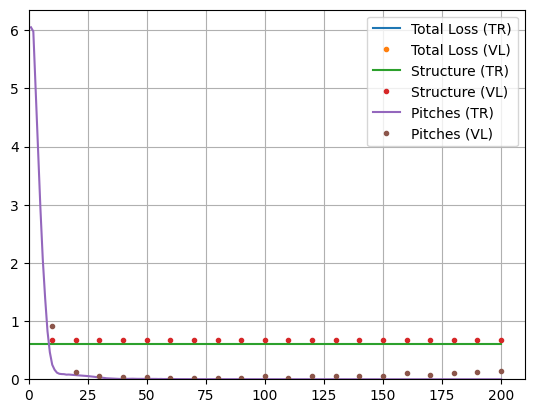

In [85]:
# Assuming your model's directory is 'model_dir'
plot_losses(model_dir='output/model_change_activities', losses=['tot', 'structure', 'pitch'], plot_val=True)

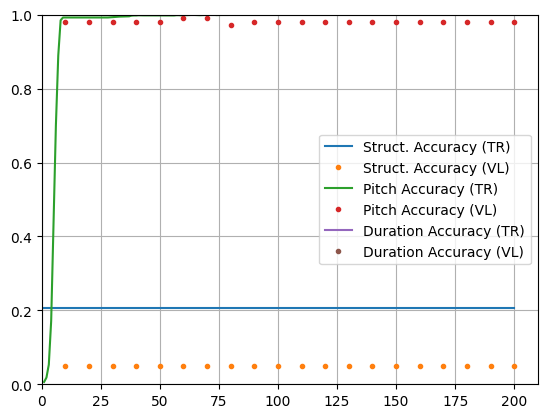

In [86]:
# Assuming your model's directory is 'model_dir'
plot_accuracies(model_dir='output/model_change_activities', accuracies=['s_acc', 'pitch', 'dur'], plot_val=True)

# Plotting Reconstruction

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_original_data(data, title='Original Data', samples=5):
    plt.figure(figsize=(10, 6))
    for i in range(samples):
        plt.subplot(samples, 1, i+1) 
        plt.plot(data[i], marker='o', linestyle='-')
        plt.title(f"{title} for Sample {i+1}")
        plt.ylabel('Value')
    plt.xlabel('Timestep')
    plt.tight_layout()
    plt.show()

#plot_original_data(emotions, title='Original Emotions')


# Generation

In [ ]:
def generate_music(vae, z, s_cond=None, s_tensor_cond=None):

    # Decoder pass to get structure and content logits
    print(z.shape)
    #print(s_cond.shape)
    s_logits, c_logits = vae.decoder(z, s_cond)
    print(s_logits)
    print(c_logits)

    if s_tensor_cond is not None:
        s_tensor = s_tensor_cond
    else:
        # Compute binary structure tensor from logits
        s_tensor = vae.decoder._binary_from_logits(s_logits)

    # Build (n_batches x n_bars x n_tracks x n_timesteps x Sigma x d_token)
    # multitrack pianoroll tensor containing logits for each activation and
    # hard silences elsewhere
    mtp = mtp_from_logits(c_logits, s_tensor)

    return mtp, s_tensor

In [ ]:
def mtp_from_logits(c_logits, s_tensor):

    mtp = torch.zeros((s_tensor.size(0), s_tensor.size(1), s_tensor.size(2),
                       s_tensor.size(3), c_logits.size(-2), c_logits.size(-1)),
                      device=c_logits.device, dtype=c_logits.dtype)

    size = mtp.size()
    mtp = mtp.reshape(-1, mtp.size(-2), mtp.size(-1))
    silence = torch.zeros((mtp.size(-2), mtp.size(-1)),
                          device=c_logits.device, dtype=c_logits.dtype)

    # Create silences with pitch EOS and PAD tokens
    silence[0, PitchToken.EOS.value] = 1.
    silence[1:, PitchToken.PAD.value] = 1.

    # Fill the multitrack pianoroll
    mtp[s_tensor.bool().reshape(-1)] = c_logits
    mtp[torch.logical_not(s_tensor.bool().reshape(-1))] = silence
    mtp = mtp.reshape(size)

    return mtp

In [ ]:
def generate_z(bs, d_model, device):
    shape = (bs, d_model)

    z_norm = torch.normal(
        torch.zeros(shape, device=device),
        torch.ones(shape, device=device)
    )

    return z_norm


def load_model(model_dir, device):
    checkpoint_path = os.path.join(model_dir, 'checkpoint')
    config_path = os.path.join(model_dir, 'configuration.json')

    checkpoint = torch.load(checkpoint_path, map_location='cpu')
    
    with open(config_path, 'r') as config_file:
        configuration = json.load(config_file)

    state_dict = checkpoint['model_state_dict']

    # Adjust the instantiation of the model according to how the configuration is structured
    # Example assumes configuration contains all necessary keyword arguments under 'model' key
    model = VAE(**configuration['model'], device=device).to(device)
    model.load_state_dict(state_dict)
    model.eval()

    return model, configuration

In [ ]:
# Configuration
model_dir = "/home/elygao/output/model"
output_dir = "/home/elygao/generate"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_sequences = 5
n_loops = 1
include_audio = True
s_file_path = "/home/elygao/structure.json"
d_model = 512 # Dimension of the latent space
n_bars = 2
n_tracks = 4
n_timesteps = 32
seed = 42


print_divider()
print("Loading the model on {} device...".format(device))
model, configuration = load_model(model_dir, device)
if model is not None:
    print("Model loaded successfully.")
else:
    print("Failed to load the model.")

————————————————————————————————————————
Loading the model on cuda device...


/home/elygao/.local/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'nn.glob.GlobalAttention' is deprecated, use 'nn.aggr.AttentionalAggregation' instead
  warnings.warn(out)


Model loaded successfully.


In [ ]:
# Load structure tensor if specified
s_tensor = None
s = None

if s_file_path:
    with open(s_file_path, 'r') as f:
        s_tensor_json = json.load(f)
    s_tensor = torch.tensor(s_tensor_json, dtype=bool)

    dims = list(s_tensor.size())
    expected = [n_bars, n_tracks, n_timesteps]
    if dims != expected:
        raise ValueError(f"Loaded structure tensor dimensions {dims} do not match expected dimensions {expected}")
    
    empty_mask = ~s_tensor.any(dim=-1).any(dim=-1)
    if empty_mask.any():
        idxs = torch.nonzero(empty_mask, as_tuple=True)
        s_tensor[idxs + (0, 0)] = True
    s_tensor = s_tensor.unsqueeze(0).repeat(n_sequences, 1, 1, 1)
    s = model.decoder._structure_from_binary(s_tensor)

print("Generating latent variables z...")
z = generate_z(n_sequences, d_model, device)
print(z.shape)
print(s_tensor.shape)

print("Generating music with the model...")
start_time = time.time()
mtp, s_tensor_generated = generate_music(model, z, s, s_tensor)
print("Inference time: {:.3f} s".format(time.time() - start_time))

features shape: torch.Size([10, 4])
is_drum shape: torch.Size([10])
features shape: torch.Size([20, 4])
is_drum shape: torch.Size([20])
features shape: torch.Size([10, 4])
is_drum shape: torch.Size([10])
features shape: torch.Size([20, 4])
is_drum shape: torch.Size([20])
features shape: torch.Size([10, 4])
is_drum shape: torch.Size([10])
features shape: torch.Size([20, 4])
is_drum shape: torch.Size([20])
features shape: torch.Size([10, 4])
is_drum shape: torch.Size([10])
features shape: torch.Size([20, 4])
is_drum shape: torch.Size([20])
features shape: torch.Size([10, 4])
is_drum shape: torch.Size([10])
features shape: torch.Size([20, 4])
is_drum shape: torch.Size([20])
Generating latent variables z...
torch.Size([5, 512])
torch.Size([5, 2, 4, 32])
Generating music with the model...
torch.Size([5, 512])


/home/elygao/.local/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


tensor([[[[0.1140, 0.0934, 0.0826,  ..., 0.0872, 0.0887, 0.0877],
          [0.1207, 0.1131, 0.1069,  ..., 0.0807, 0.0838, 0.0831],
          [0.1281, 0.1114, 0.1080,  ..., 0.1058, 0.0941, 0.0657],
          [0.1277, 0.1396, 0.1425,  ..., 0.0893, 0.0944, 0.0922]],

         [[0.1100, 0.1063, 0.1031,  ..., 0.0973, 0.1080, 0.0956],
          [0.1131, 0.1090, 0.0910,  ..., 0.0757, 0.0724, 0.0677],
          [0.1074, 0.0881, 0.0920,  ..., 0.0906, 0.0904, 0.0783],
          [0.1326, 0.1394, 0.1345,  ..., 0.1026, 0.1073, 0.1030]]],


        [[[0.1117, 0.0942, 0.0924,  ..., 0.0918, 0.1119, 0.1043],
          [0.0938, 0.0810, 0.0854,  ..., 0.0822, 0.0891, 0.0853],
          [0.1219, 0.0966, 0.0874,  ..., 0.1001, 0.0920, 0.0679],
          [0.1165, 0.1257, 0.1273,  ..., 0.0884, 0.0922, 0.0912]],

         [[0.1078, 0.1057, 0.0927,  ..., 0.1129, 0.1170, 0.1037],
          [0.1200, 0.1166, 0.1113,  ..., 0.1185, 0.1163, 0.0993],
          [0.1073, 0.1007, 0.0884,  ..., 0.1084, 0.1056, 0.0797],
  

In [ ]:
s_tensor_generated.shape

torch.Size([5, 2, 4, 32])

In [ ]:
mtp.shape

torch.Size([5, 2, 4, 32, 15, 230])

In [ ]:
n_sequences, n_bars, n_tracks, n_timesteps, n_features, n_tokens = mtp.shape
target_timesteps = n_bars * n_timesteps  # Combining bars and timesteps
target_tracks = n_tracks  # Maintaining the same number of tracks

mtp_reshaped = mtp.reshape(n_sequences, target_tracks, target_timesteps, n_features, n_tokens)

In [ ]:
import torch

def transform_data(mtp, s_tensor_generated):
    # Parameters for the dimensions
    n_sequences, n_bars, n_tracks, n_timesteps, n_features, n_tokens = mtp.shape

    # Desired output dimensions
    target_timesteps = n_bars * n_timesteps  # Combining bars and timesteps
    target_tracks = n_tracks  # Maintaining the same number of tracks

    # Reshape mtp and s_tensor to collapse the bars and timesteps into one dimension
    mtp_reshaped = mtp.reshape(n_sequences, target_tracks, target_timesteps, n_features, n_tokens)
    s_tensor_reshaped = s_tensor_generated.reshape(n_sequences, target_tracks, target_timesteps)

    # Assuming that the first 230 tokens are pitch and duration tokens
    # Extracting pitch and duration from the last dimension, here just taking a slice as an example
    pitch_and_duration = mtp_reshaped[..., :230]  # Adjust if pitch and duration are stored differently

    # Reducing the dimensions by concatenating the pitch and duration data
    c_tensor = pitch_and_duration.reshape(n_sequences, target_tracks, target_timesteps, 2)  # Adjust the last dimension based on actual data structure

    # Reshape s_tensor to the final desired shape [n_sequences, target_tracks * target_timesteps]
    s_tensor_final = s_tensor_reshaped.reshape(n_sequences, target_tracks * target_timesteps)

    return c_tensor, s_tensor_final

# Example usage
#mtp = torch.rand(5, 2, 4, 32, 15, 230)  # Simulated data
#s_tensor_generated = torch.randint(0, 2, (5, 2, 4, 32), dtype=torch.bool)  # Simulated binary structure tensor

#c_tensor, s_tensor = transform_data(mtp, s_tensor_generated)
#print("Shape of c_tensor:", c_tensor.shape)  # Should be [5, 4, 64, 2]
#print("Shape of s_tensor:", s_tensor.shape)  # Should be [5, 256]


RuntimeError: shape '[5, 4, 64, 2]' is invalid for input of size 4416000